<a href="https://colab.research.google.com/github/Josue-B-Navarrete/AI_Projects/blob/main/Heart_Attack_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Describe the features

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

# Data Exploratory Analysis

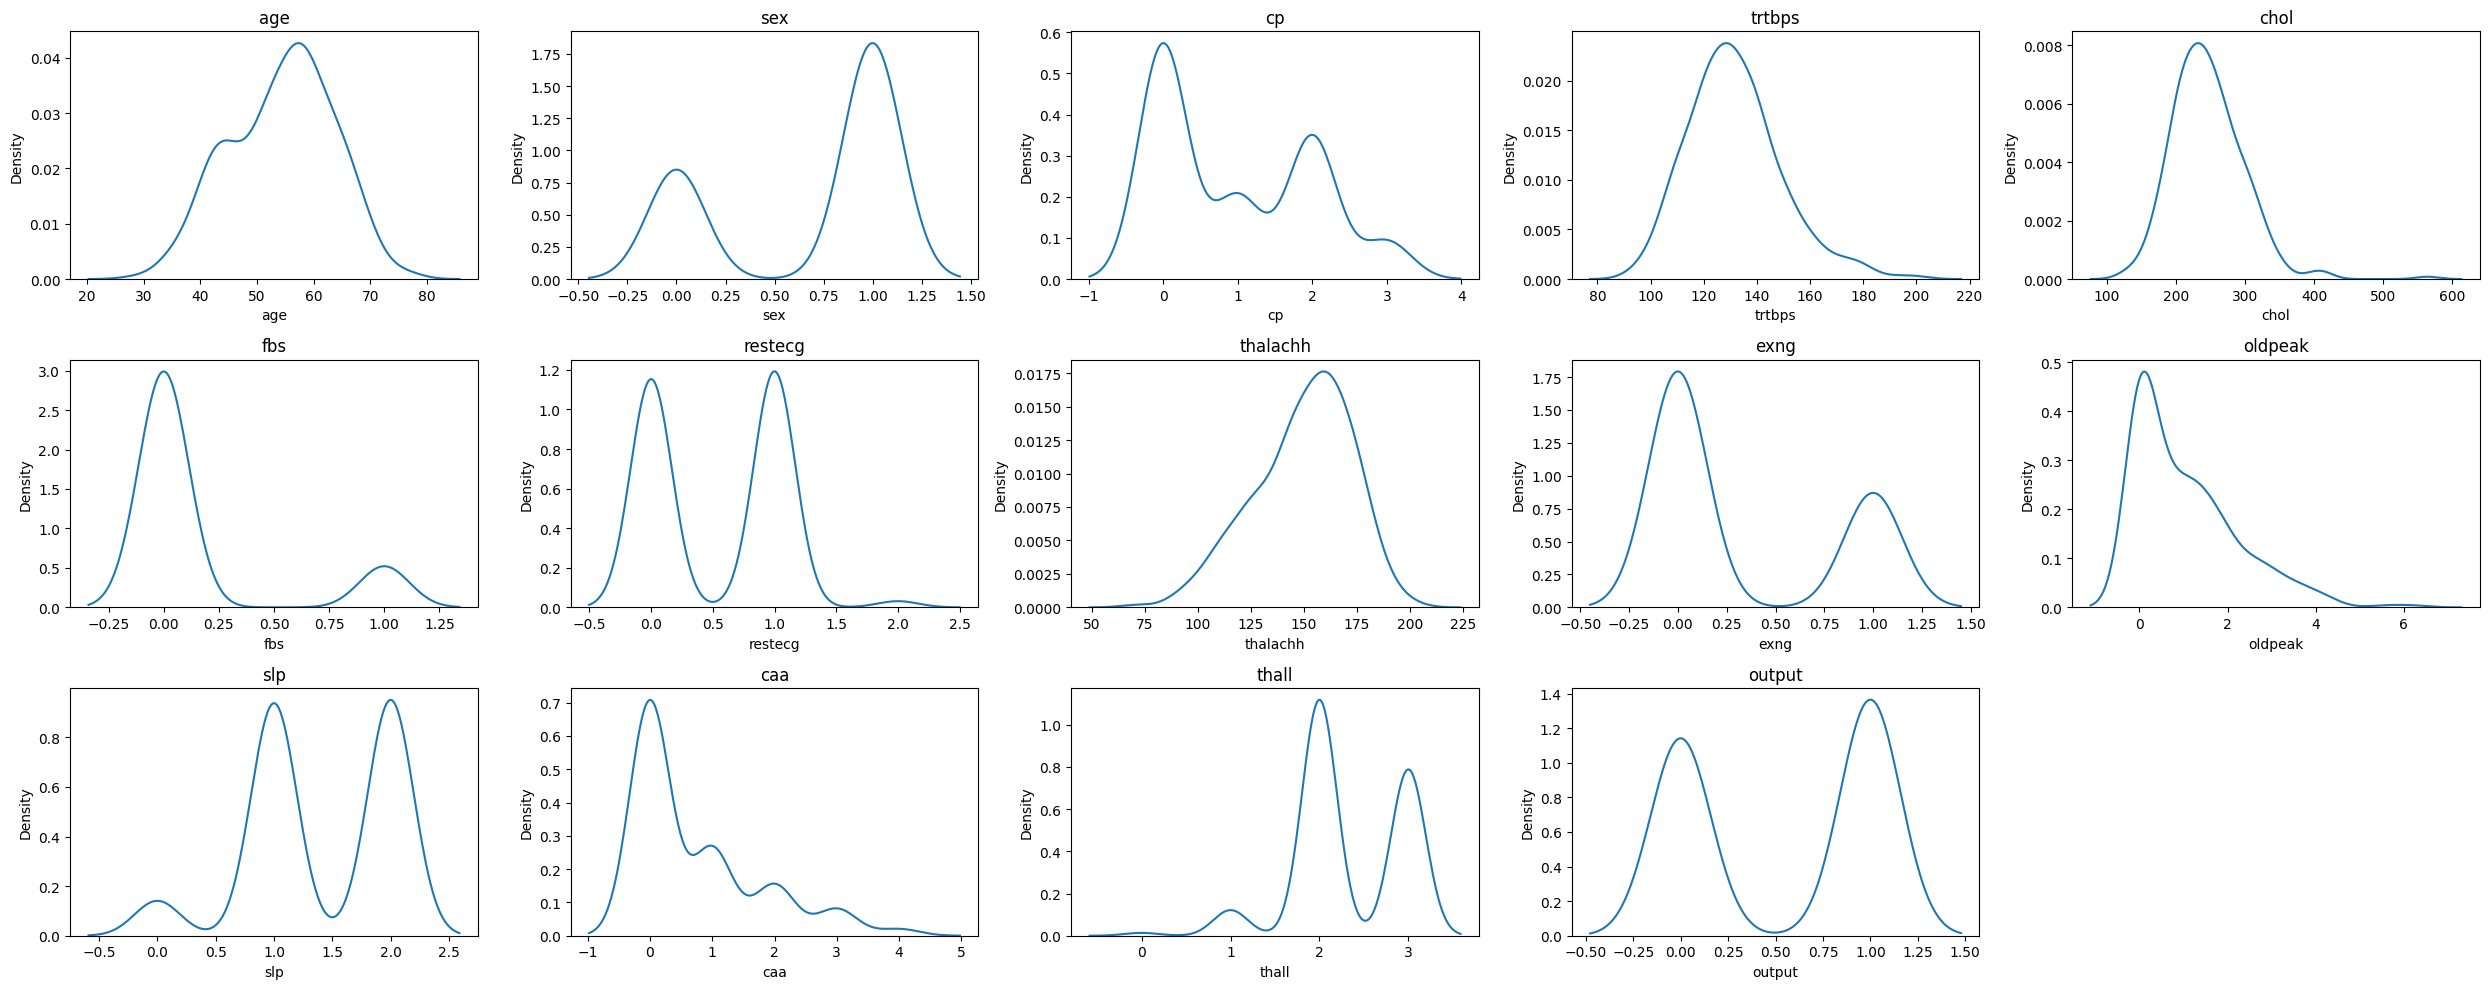

In [ ]:
heart_df.describe()

fig, axes = plt.subplots(3, 5, figsize=(25, 10))
axes = axes.flatten()
for i, column in enumerate(heart_df.columns):
    sns.kdeplot(heart_df, x=column, ax=axes[i])
    axes[i].set_title(f"{column}")
for j in range(len(heart_df.columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

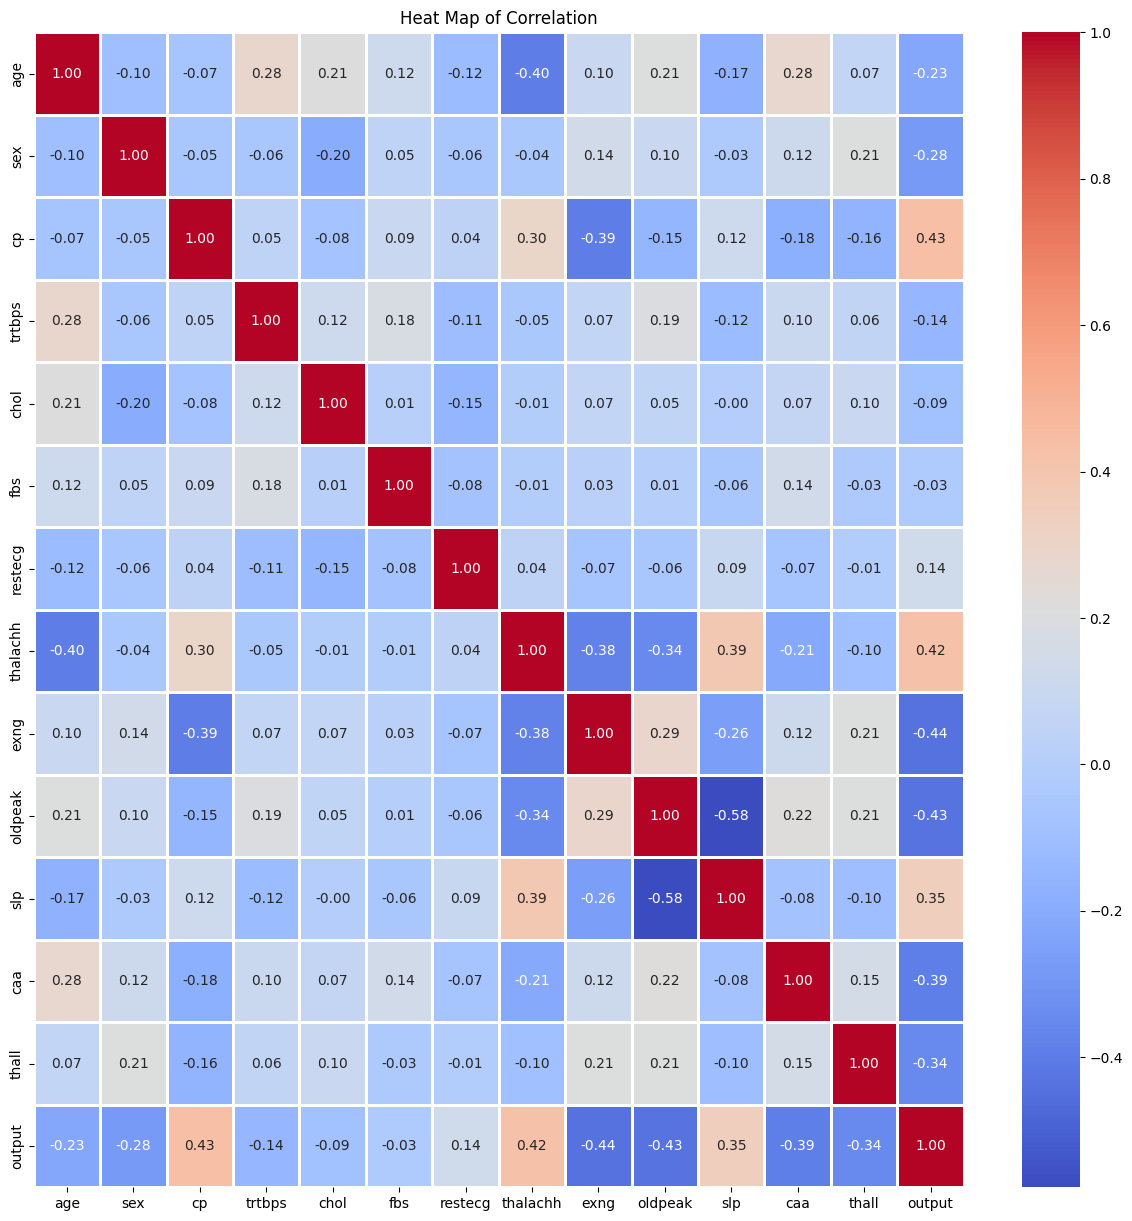

In [ ]:
corr = heart_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title("Heat Map of Correlation")
plt.show()

<Axes: xlabel='sex', ylabel='output'>

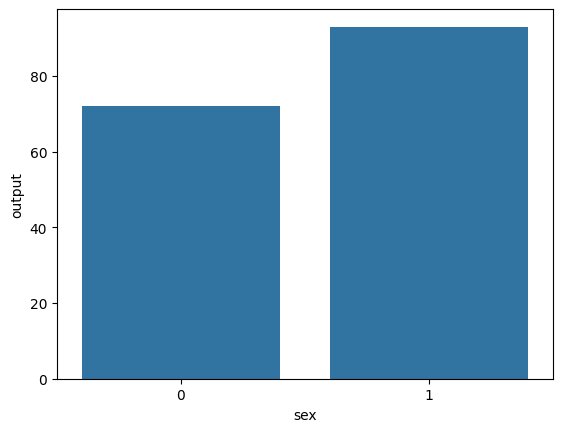

In [ ]:
df1 = heart_df.groupby('sex').agg({"output":'sum'}).reset_index()
sns.barplot(x='sex',y='output',data=df1)

Men seem to exprience more chances of a Heart Attack



<Axes: xlabel='cp', ylabel='output'>

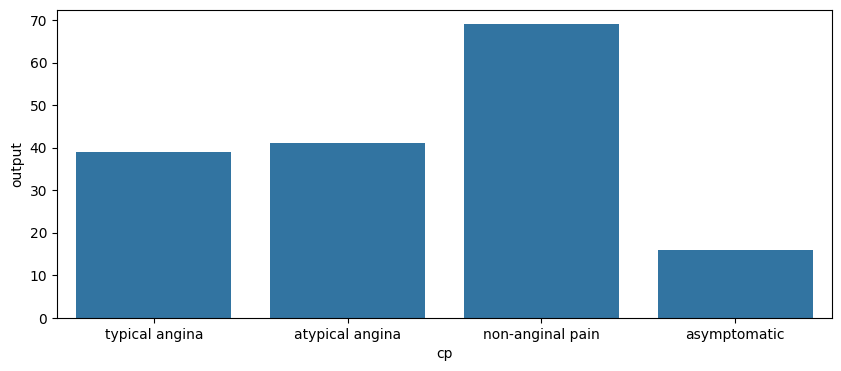

In [ ]:
def replace(x):
    if x==0:
        return "typical angina"
    elif x==1:
        return "atypical angina"
    elif x==2:
        return "non-anginal pain"
    else:
        return "asymptomatic"
df1=heart_df.groupby('cp').agg({"output":'sum'}).reset_index()
df1['cp']=df1['cp'].apply(lambda x:replace(x))

plt.figure(figsize=(10,4))
sns.barplot(x='cp',y='output',data=df1)

###**Non Anginal Pain is high for heart attacks followed by Atypical Angina**
- Non-anginal pain: Chest pain not related to heart problems, often sharp or stabbing in nature, may be triggered by movement, and commonly caused by musculoskeletal issues, acid reflux, or anxiety.

- Atypical angina: Chest pain that partially resembles heart-related pain but doesn't match all classic angina criteria; meets only 1-2 typical characteristics of heart pain and may present with unusual symptoms or locations.

# Rules Based Approach

In [ ]:
# Calculate risk scores based on age only
risk_scores = []
for age in heart_df['age']:
    if age >= 65:
        risk_scores.append(75)    # High risk
    elif age >= 55:
        risk_scores.append(65)    # Moderate-high risk
    elif age >= 45:
        risk_scores.append(55)    # Moderate risk
    elif age >= 35:
        risk_scores.append(45)    # Moderate-low risk
    else:
        risk_scores.append(35)    # Low risk

# Convert risk scores to predictions (1 if risk >= 60, else 0)
predictions = [1 if score >= 60 else 0 for score in risk_scores]

# Calculate accuracy
correct_predictions = sum(1 for pred, actual in zip(predictions, heart_df['output']) if pred == actual)
accuracy = correct_predictions / len(heart_df)

# Print results
print("\nAge-Based Model Results:")
print(f"Total cases: {len(heart_df)}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {len(heart_df) - correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

# Age group analysis
age_ranges = ['<35', '35-45', '45-55', '55-65', '65+']
for age_range in age_ranges:
    if age_range == '<35':
        mask = heart_df['age'] < 35
    elif age_range == '35-45':
        mask = (heart_df['age'] >= 35) & (heart_df['age'] < 45)
    elif age_range == '45-55':
        mask = (heart_df['age'] >= 45) & (heart_df['age'] < 55)
    elif age_range == '55-65':
        mask = (heart_df['age'] >= 55) & (heart_df['age'] < 65)
    else:  # '65+'
        mask = heart_df['age'] >= 65

    group_total = sum(mask)
    group_actual = sum(heart_df[mask]['output'])
    group_predicted = sum(1 for i, m in enumerate(mask) if m and predictions[i] == 1)
    group_accuracy = sum(1 for i, m in enumerate(mask) if m and predictions[i] == heart_df['output'].iloc[i]) / group_total if group_total > 0 else 0

    print(f"\nAge Group {age_range}:")
    print(f"Total patients: {group_total}")
    print(f"Actual positive cases: {group_actual}")
    print(f"Predicted positive cases: {group_predicted}")
    print(f"Group accuracy: {group_accuracy:.2%}")


Age-Based Model Results:
Total cases: 303
Correct predictions: 109
Incorrect predictions: 194
Accuracy: 35.97%

Age Group <35:
Total patients: 3
Actual positive cases: 3
Predicted positive cases: 0
Group accuracy: 0.00%

Age Group 35-45:
Total patients: 53
Actual positive cases: 39
Predicted positive cases: 0
Group accuracy: 26.42%

Age Group 45-55:
Total patients: 88
Actual positive cases: 58
Predicted positive cases: 0
Group accuracy: 34.09%

Age Group 55-65:
Total patients: 118
Actual positive cases: 44
Predicted positive cases: 118
Group accuracy: 37.29%

Age Group 65+:
Total patients: 41
Actual positive cases: 21
Predicted positive cases: 41
Group accuracy: 51.22%


## Rules Based with CP, Exang, and Age

In [ ]:
def classify_heart_disease(row):
    # Age ranges, with cp and exng penalties
    if row['age'] < 35:
        if row['cp'] in [2, 3] and row['exng'] == 1:
            return 1
        else:
            return 0

    elif 35 <= row['age'] <= 45:
        if row['cp'] >= 1 and row['exng'] == 1:
            return 1
        else:
            return 0

    elif 46 <= row['age'] <= 55:
        if row['cp'] in [2, 3] or row['exng'] == 1:
            return 1
        else:
            return 0

    elif 56 <= row['age'] <= 65:
        if row['cp'] >= 1 or row['exng'] == 1:
            return 1
        else:
            return 0

    else:  # Age > 65
        if row['cp'] in [1, 2, 3] or row['exng'] == 1:
            return 1
        else:
            return 0

heart_df = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')

heart_df['predicted_output'] = heart_df.apply(classify_heart_disease, axis=1)

age_groups = {
    '<35': (heart_df['age'] < 35),
    '35-45': (heart_df['age'] >= 35) & (heart_df['age'] <= 45),
    '46-55': (heart_df['age'] >= 46) & (heart_df['age'] <= 55),
    '56-65': (heart_df['age'] >= 56) & (heart_df['age'] <= 65),
    '>65': (heart_df['age'] > 65)
}

print("Accuracy for each age group:")
for group_name, condition in age_groups.items():
    group_data = heart_df[condition]
    correct_predictions = (group_data['output'] == group_data['predicted_output']).sum()
    accuracy = correct_predictions / len(group_data)
    print(f"{group_name}: {accuracy:.2%}")

print("Confusion Matrix:")
print(confusion_matrix(heart_df['output'], heart_df['predicted_output']))
print("\nClassification Report:")
print(classification_report(heart_df['output'], heart_df['predicted_output']))

Accuracy for each age group:
<35: 0.00%
35-45: 29.51%
46-55: 47.73%
56-65: 45.76%
>65: 51.52%
Confusion Matrix:
[[46 92]
 [80 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.33      0.35       138
           1       0.48      0.52      0.50       165

    accuracy                           0.43       303
   macro avg       0.42      0.42      0.42       303
weighted avg       0.43      0.43      0.43       303



# Feature engineering

In [ ]:
def get_age_group(age):
    if age < 35:
        return '<35'
    elif age < 45:
        return '35-45'
    elif age < 55:
        return '45-55'
    elif age < 65:
        return '55-65'
    else:
        return '65+'

# Add new column with age groups
heart_df['age_group'] = heart_df['age'].apply(get_age_group)

# Create dummy variables for age groups
age_dummies = pd.get_dummies(heart_df['age_group'], prefix='age')

# Add the dummy columns to the original dataframe
heart_df = pd.concat([heart_df, age_dummies], axis=1)

<Axes: xlabel='age_group', ylabel='output'>

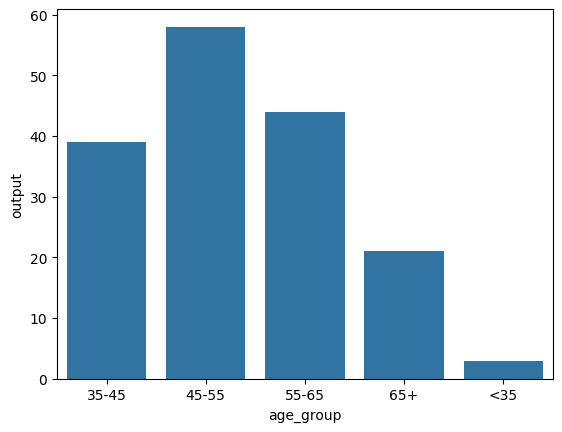

In [ ]:
df3 = heart_df.groupby('age_group').agg({"output":'sum'}).reset_index()
sns.barplot(x='age_group',y='output',data=df3)

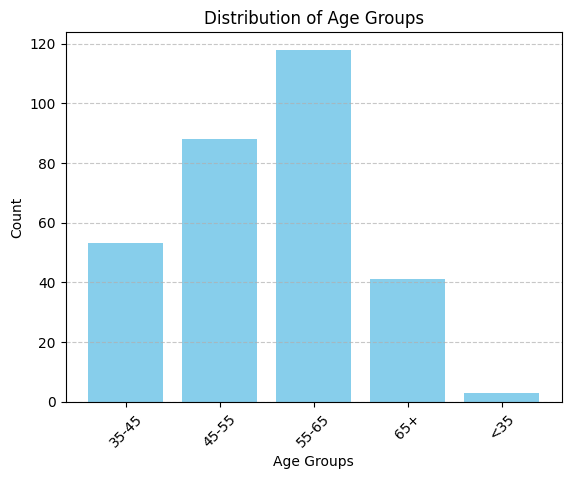

In [ ]:
age_counts = heart_df['age_group'].value_counts().sort_index()
plt.bar(age_counts.index, age_counts.values, color='skyblue')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)


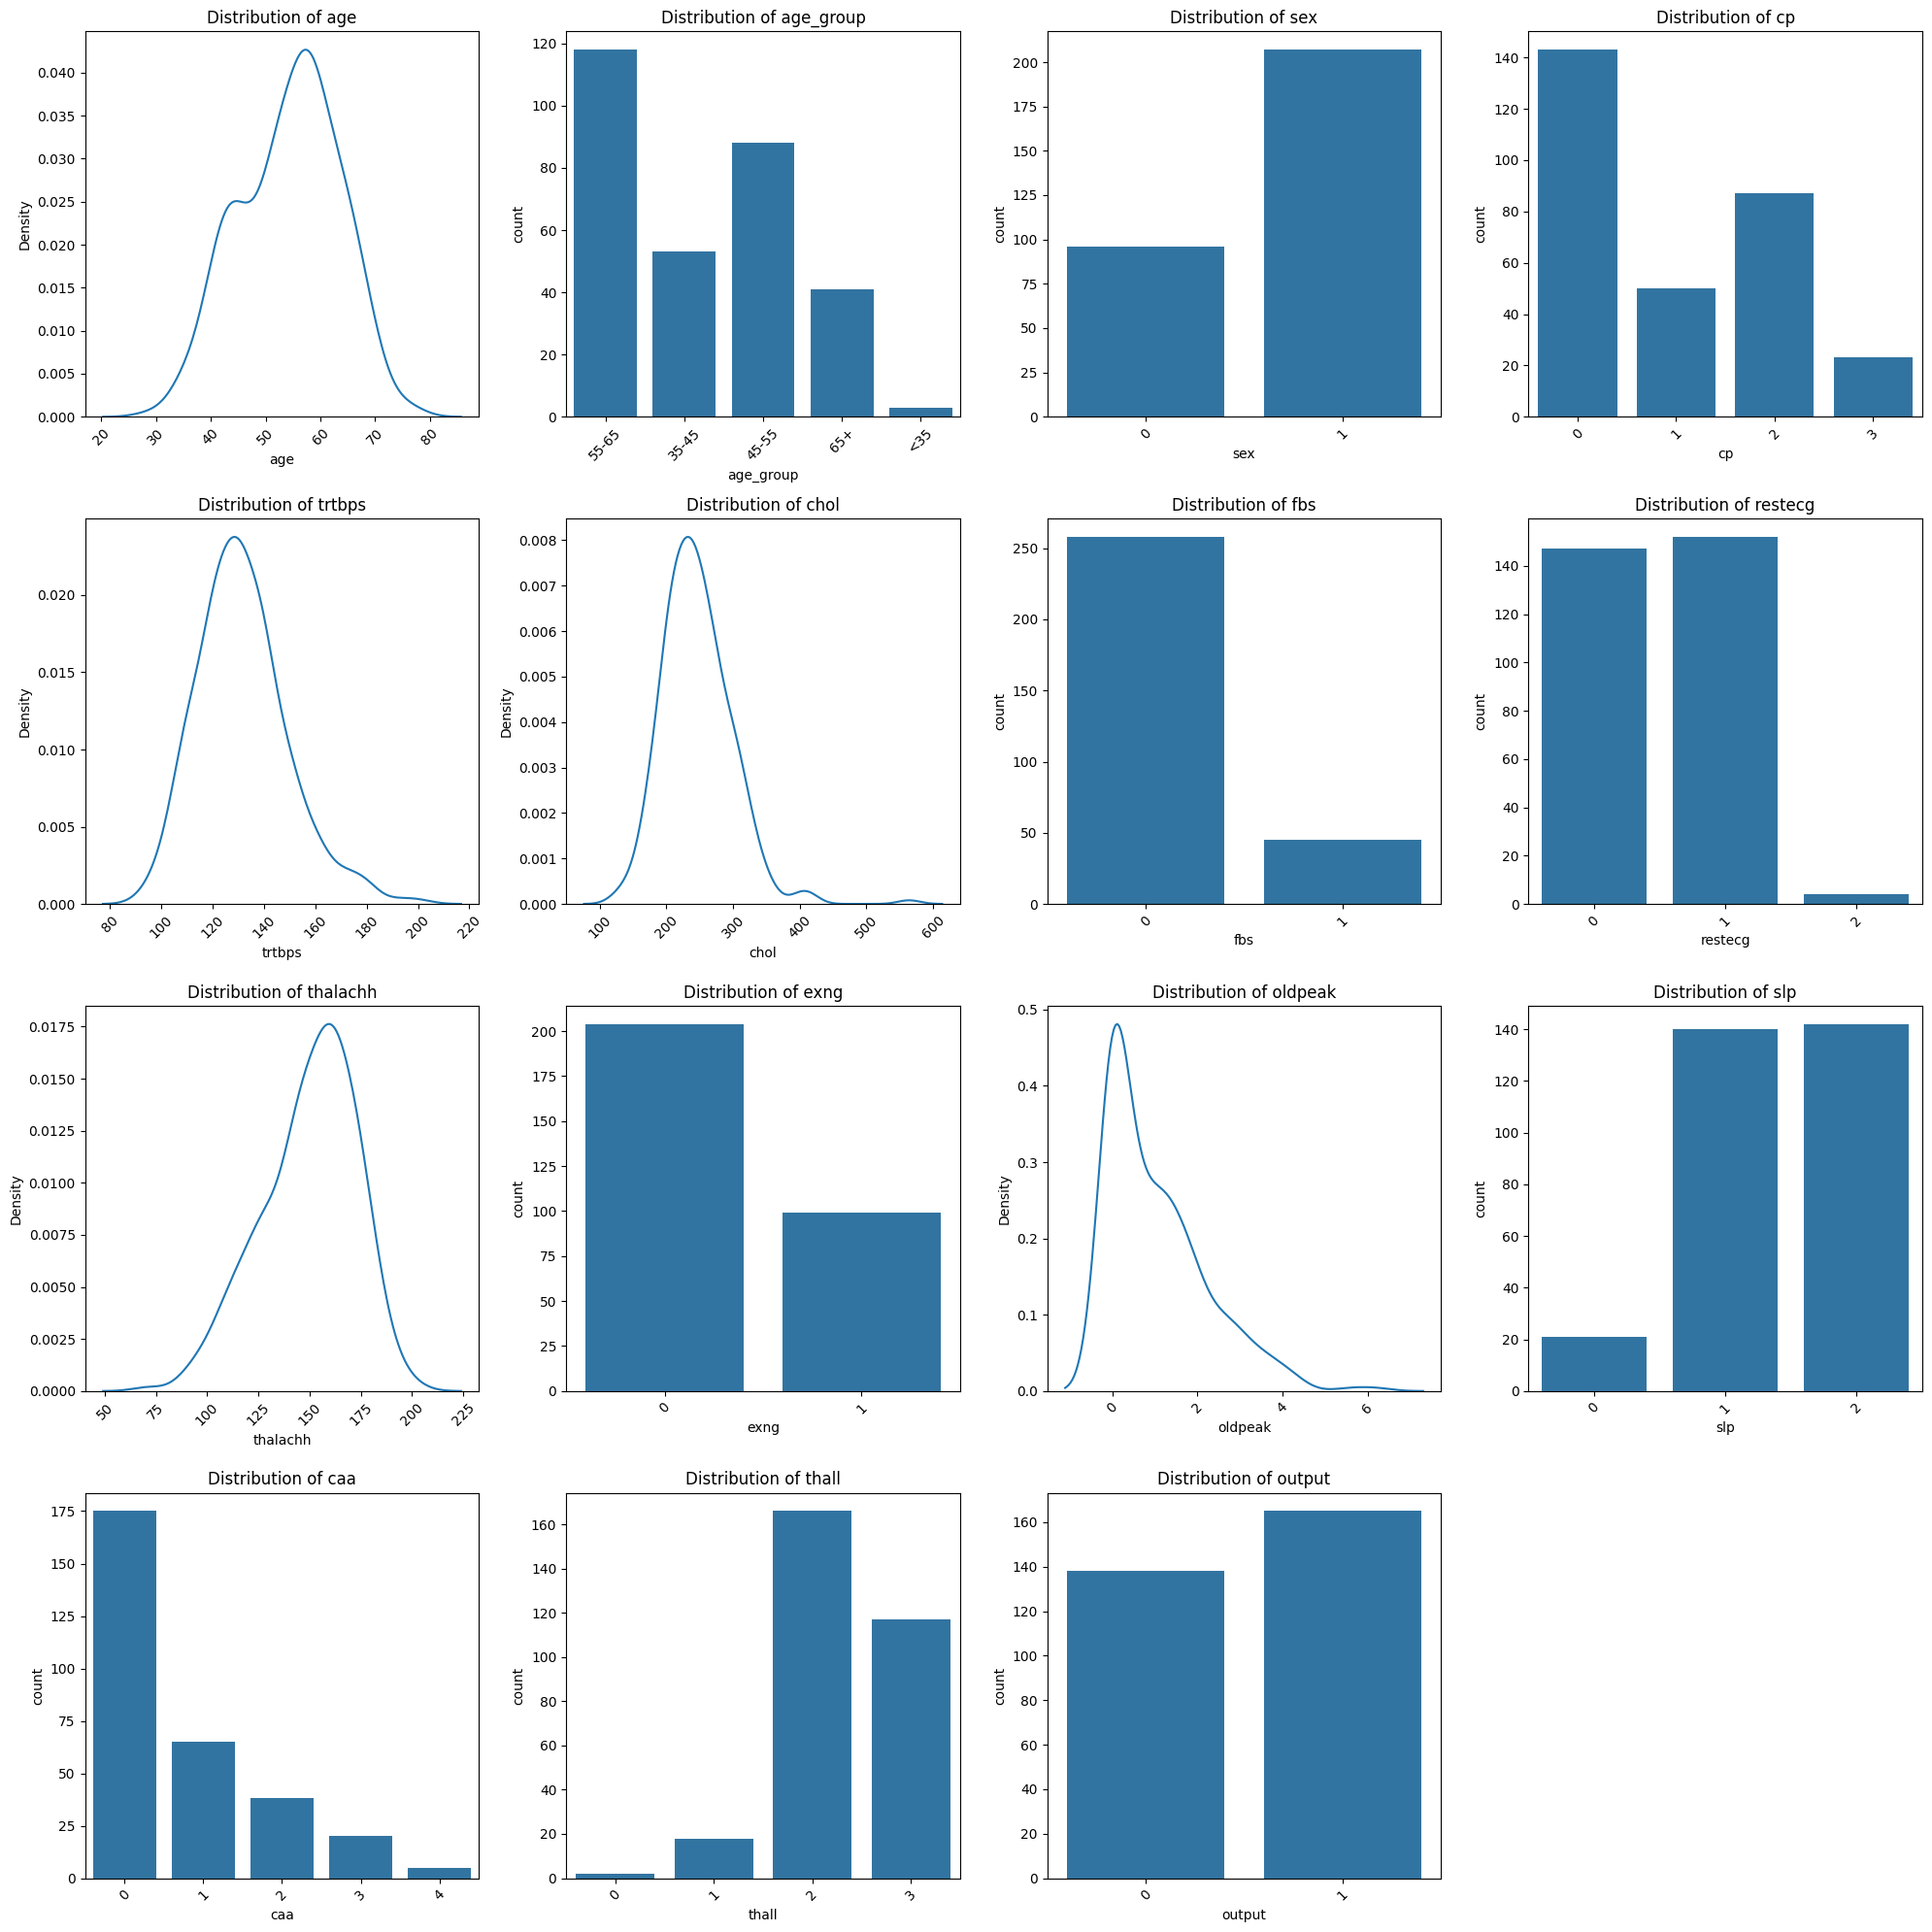

In [ ]:
import seaborn as sns

# Set up the plot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

# Variables to plot
variables = ['age', 'age_group', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg',
            'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

# Plot each variable
for idx, var in enumerate(variables):
    if var in ['age_group', 'sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']:
        # For categorical variables
        sns.countplot(data=heart_df, x=var, ax=axes[idx])
    else:
        # For continuous variables
        sns.kdeplot(data=heart_df, x=var, ax=axes[idx])

    axes[idx].set_title(f'Distribution of {var}')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()


0
[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77]
298    57
299    45
300    68
301    57
302    57
Name: age, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



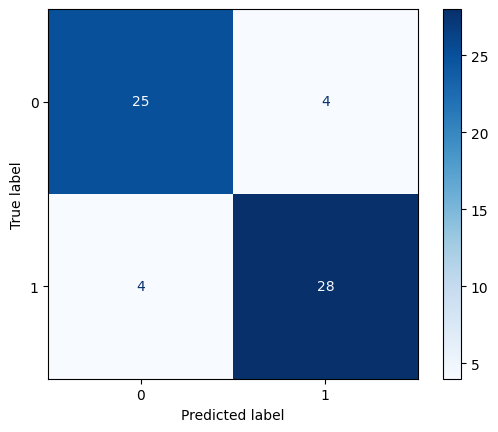

In [ ]:
heart_df_new = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')
print(heart_df_new['age'].isnull().sum())
print(heart_df_new['age'].unique())
print(heart_df_new['age'].tail())
age_mapping = {'<35': 0, '35-44': 1, '45-54': 2, '55-64': 3, '65+': 4}


heart_df_new['age_group'] = pd.cut(heart_df_new['age'], bins=[0, 35, 45, 55, 65, 100], labels=['<35', '35-44', '45-54', '55-64', '65+'])
heart_df_new['age_group'] = heart_df_new['age_group'].map(age_mapping)




X = heart_df_new.drop(columns=['output'])
y = heart_df_new['output']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=log_reg_model.classes_)
disp.plot(cmap='Blues')
plt.show()

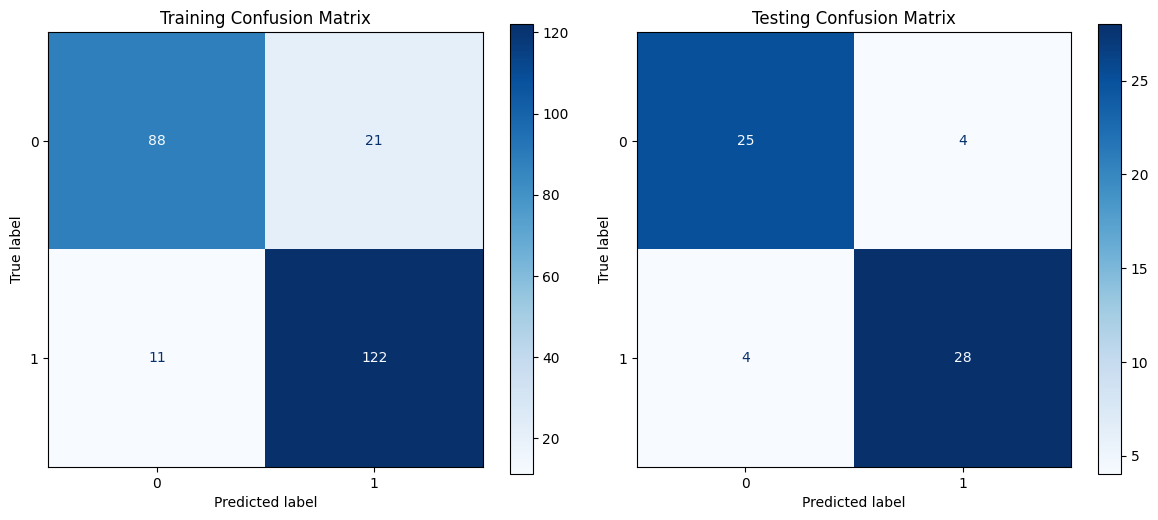


Training Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       109
           1       0.85      0.92      0.88       133

    accuracy                           0.87       242
   macro avg       0.87      0.86      0.87       242
weighted avg       0.87      0.87      0.87       242


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess data
heart_df_new = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')

# Create age groups
age_mapping = {'<35': 0, '35-44': 1, '45-54': 2, '55-64': 3, '65+': 4}
heart_df_new['age_group'] = pd.cut(heart_df_new['age'],
                                  bins=[0, 35, 45, 55, 65, 100],
                                  labels=['<35', '35-44', '45-54', '55-64', '65+'])
heart_df_new['age_group'] = heart_df_new['age_group'].map(age_mapping)

# Prepare features and target
X = heart_df_new.drop(columns=['output'])
y = heart_df_new['output']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# Get predictions for both training and test sets
y_train_pred = log_reg_model.predict(X_train)
y_test_pred = log_reg_model.predict(X_test)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training confusion matrix
train_conf_mat = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=train_conf_mat,
                      display_labels=log_reg_model.classes_).plot(ax=ax1, cmap='Blues')
ax1.set_title('Training Confusion Matrix')

# Plot testing confusion matrix
test_conf_mat = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=test_conf_mat,
                      display_labels=log_reg_model.classes_).plot(ax=ax2, cmap='Blues')
ax2.set_title('Testing Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Confusion Matrix:
 [[24  5]
 [ 5 27]]
Accuracy Score: 0.8360655737704918


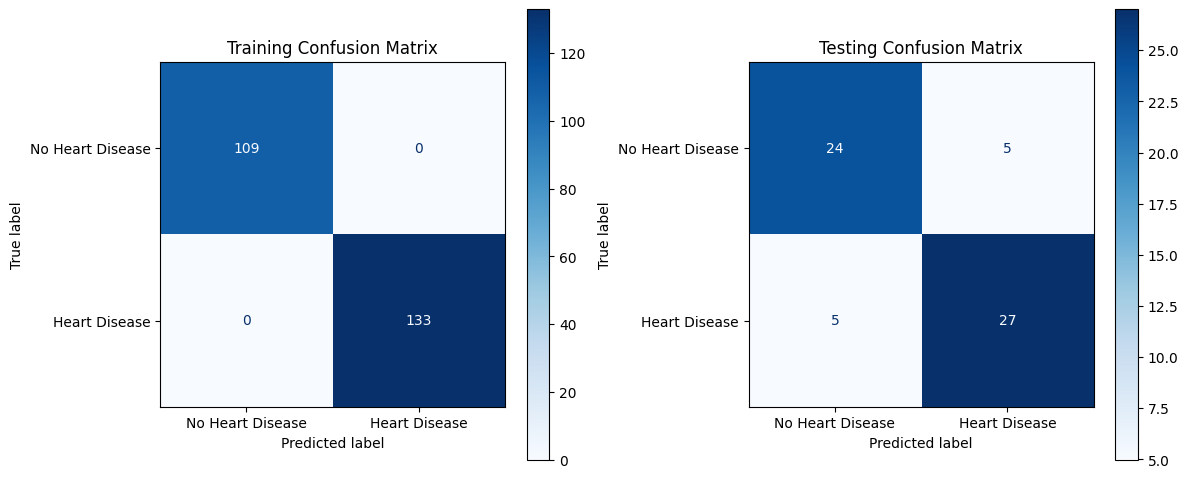


Training Metrics:
Confusion Matrix:
[[109   0]
 [  0 133]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       133

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

Accuracy Score: 1.0

Testing Metrics:
Confusion Matrix:
[[24  5]
 [ 5 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Accuracy Score: 0.8360655737704918


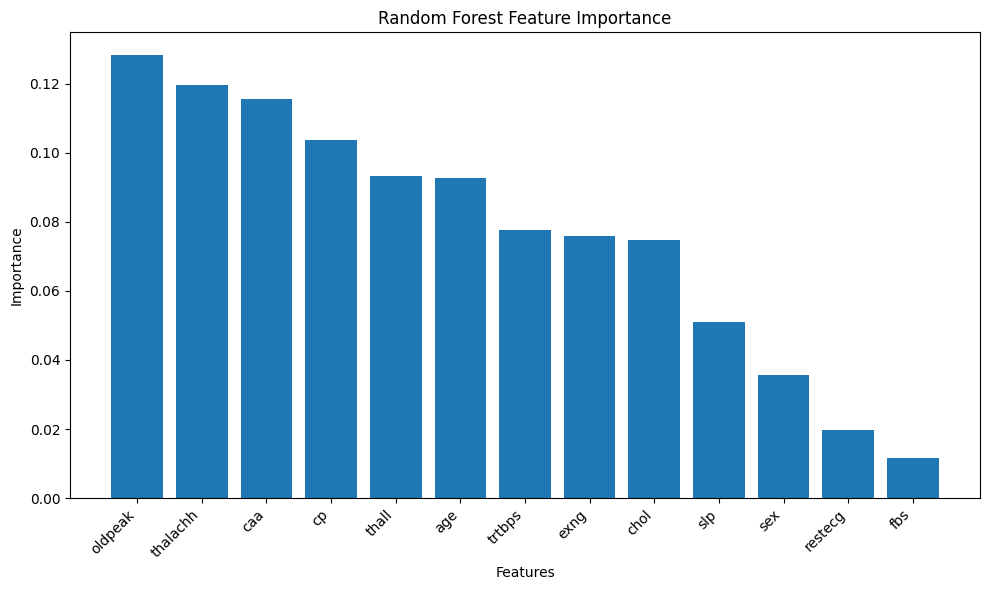

In [ ]:

# Prepare features and target
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predictions for both training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training confusion matrix
train_conf_mat = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=train_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax1, cmap='Blues')
ax1.set_title('Training Confusion Matrix')

# Plot testing confusion matrix
test_conf_mat = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=test_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax2, cmap='Blues')
ax2.set_title('Testing Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print training metrics
print("\nTraining Metrics:")
print("Confusion Matrix:")
print(train_conf_mat)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))
print("Accuracy Score:", accuracy_score(y_train, y_train_pred))

# Print testing metrics
print("\nTesting Metrics:")
print("Confusion Matrix:")
print(test_conf_mat)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("Accuracy Score:", accuracy_score(y_test, y_test_pred))

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Class distribution before SMOTE: Counter({1: 132, 0: 110})
Class distribution after SMOTE: Counter({1: 132, 0: 132})
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Score: 0.8868945868945868


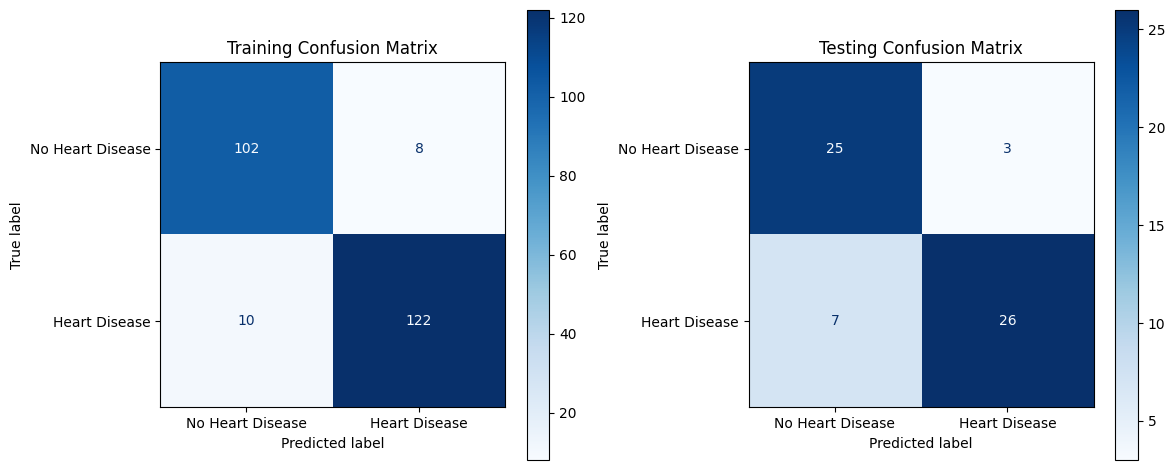


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       110
           1       0.94      0.92      0.93       132

    accuracy                           0.93       242
   macro avg       0.92      0.93      0.93       242
weighted avg       0.93      0.93      0.93       242


Training Set Confusion Matrix:
[[102   8]
 [ 10 122]]

Training Accuracy Score: 0.9256198347107438

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        28
           1       0.90      0.79      0.84        33

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


Test Set Confusion Matrix:
[[25  3]
 [ 7 26]]

Test Accuracy Score: 0.8360655737704918


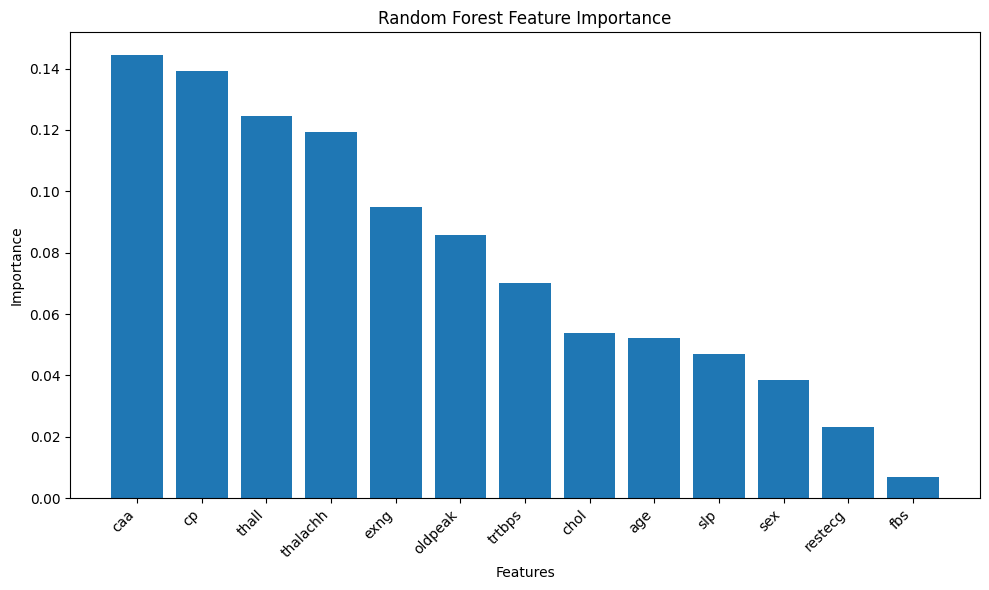

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt




# Prepare features and target
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']


feature_names = X.columns.tolist()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=701, stratify=y
)

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=701)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=701)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Grid search with 5-fold cross validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=701),
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to data
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Get best model
best_rf_model = grid_search.best_estimator_

# Training set evaluation
y_train_pred = best_rf_model.predict(X_train)
train_conf_mat = confusion_matrix(y_train, y_train_pred)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training confusion matrix
ConfusionMatrixDisplay(confusion_matrix=train_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax1, cmap='Blues')
ax1.set_title('Training Confusion Matrix')

# Test set evaluation
y_test_pred = best_rf_model.predict(X_test)
test_conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot testing confusion matrix
ConfusionMatrixDisplay(confusion_matrix=test_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax2, cmap='Blues')
ax2.set_title('Testing Confusion Matrix')

plt.tight_layout()
plt.show()

# Print classification reports
print("\nTraining Set Classification Report:")
print(classification_report(y_train, y_train_pred))
print("\nTraining Set Confusion Matrix:")
print(train_conf_mat)
print("\nTraining Accuracy Score:", accuracy_score(y_train, y_train_pred))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("\nTest Set Confusion Matrix:")
print(test_conf_mat)
print("\nTest Accuracy Score:", accuracy_score(y_test, y_test_pred))

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

SHAP oversample on training


# Boosting

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Cross-Validation Accuracy Scores: [0.81967213 0.80327869 0.7704918  0.78333333 0.76666667]
Mean Accuracy: 0.7886885245901639
Standard Deviation: 0.020087895485705852


# With default of accuracy

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}
Best Cross-Validation Score: 0.8269557823129252
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



<Figure size 1000x600 with 0 Axes>

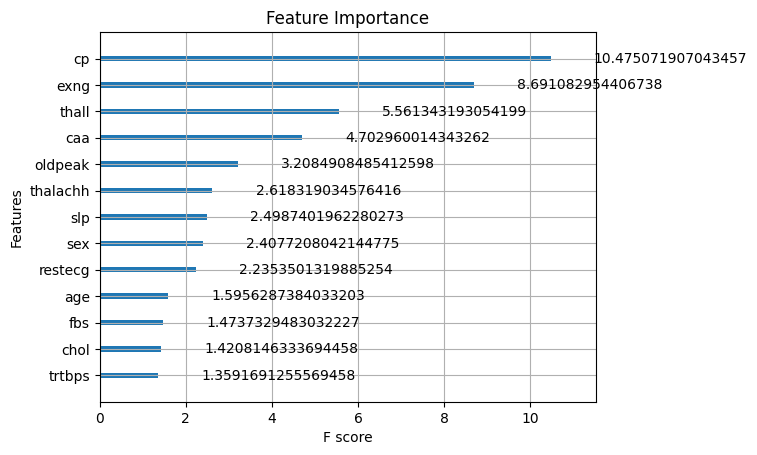

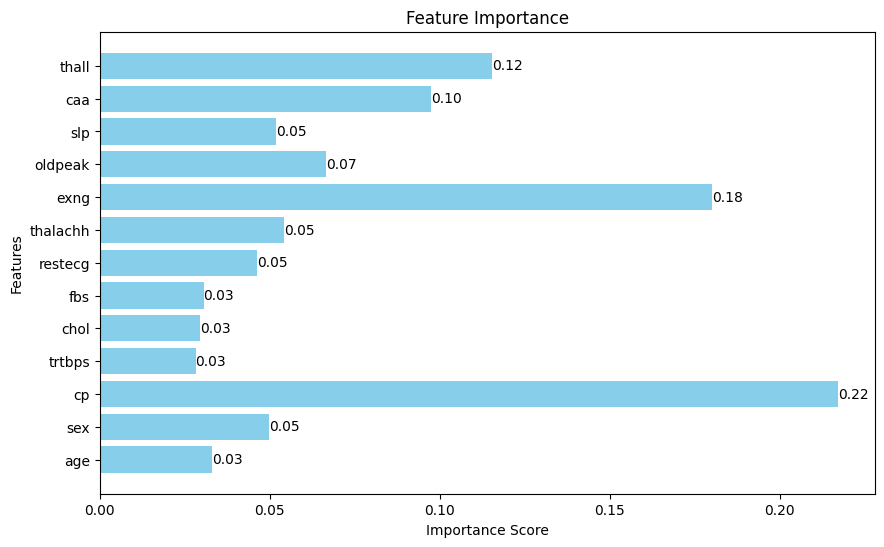

Feature names: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']
Number of features in model: 13
age: 0.03307110443711281
sex: 0.049902573227882385
cp: 0.21710701286792755
trtbps: 0.028170226141810417
chol: 0.029447894543409348
fbs: 0.03054468333721161
restecg: 0.046330008655786514
thalachh: 0.05426744744181633
exng: 0.1801319420337677
oldpeak: 0.06649938225746155
slp: 0.0517890490591526
caa: 0.09747385233640671
thall: 0.11526475101709366
age: 0.03307110443711281
sex: 0.049902573227882385
cp: 0.21710701286792755
trtbps: 0.028170226141810417
chol: 0.029447894543409348
fbs: 0.03054468333721161
restecg: 0.046330008655786514
thalachh: 0.05426744744181633
exng: 0.1801319420337677
oldpeak: 0.06649938225746155
slp: 0.0517890490591526
caa: 0.09747385233640671
thall: 0.11526475101709366


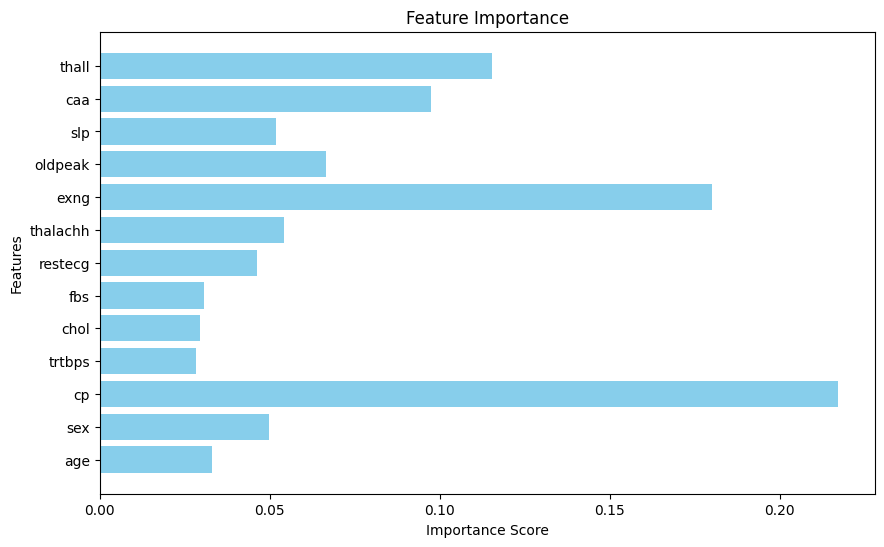

Model Features: ['age' 'sex' 'cp' 'trtbps' 'chol' 'fbs' 'restecg' 'thalachh' 'exng'
 'oldpeak' 'slp' 'caa' 'thall']
Feature Names Provided: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']


In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')

# Pre-processing / dropping output
X = heart_df.drop(columns=['output'])
y = heart_df['output']

feature_names = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Added this line
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

#Splitting data
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Splitting data with new code
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=701, stratify=y
)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=701)

# Param grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150], # Number of trees or boosting rounds
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2], # Step size for weight updates
    'reg_alpha': [0, 0.1, 1], # L1 regularization to prevent overfitting
    'reg_lambda': [1, 10, 100], # L2 regulartization to prevent overfitting
    'subsample': [0.8, 1.0], # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0] # Fractions of features used per tree
}

# Grid search w/ 5 fold cross validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=701),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluating best model on test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# plot_importance(best_xgb_model, importance_type='weight', max_num_features=len(feature_names))
# plt.title('Feature Importance')
# plt.yticks(range(len(feature_names)), feature_names)
# plt.show()

# plt.figure(figsize=(10, 6))
# # ax = plot_importance(best_xgb_model, importance_type='weight', max_num_features=len(feature_names))
# ax = plot_importance(best_xgb_model, importance_type='gain', max_num_features=len(feature_names))
# plt.title('Feature Importance')

# ax.set_yticks(range(len(feature_names)))
# ax.set_yticklabels(feature_names)

# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# Second code
# plt.figure(figsize=(10, 6))
# plot_importance(best_xgb_model, importance_type='gain')
# plt.title('Feature Importance')

# plt.barh(feature_names, importance, color='skyblue')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# Plot feature importance using plot_importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

# Extract importance values and plot with plt.barh
importance = best_xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, importance, color='skyblue')

# Adding numerical values at the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center', ha='left', color='black')

plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


print("Feature names:", feature_names)
print("Number of features in model:", len(best_xgb_model.feature_importances_))
importance = best_xgb_model.feature_importances_
for feature, score in zip(feature_names, importance):
    print(f"{feature}: {score}")
for feature, score in zip(feature_names, best_xgb_model.feature_importances_):
    print(f"{feature}: {score}")
importance = best_xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

print("Model Features:", best_xgb_model.feature_names_in_)
print("Feature Names Provided:", feature_names)


# W/emphasis on recall

Class distribution before SMOTE: Counter({1: 132, 0: 110})
Class distribution after SMOTE: Counter({1: 132, 0: 132})
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8}
Best Cross-Validation Score: 0.8877492877492879


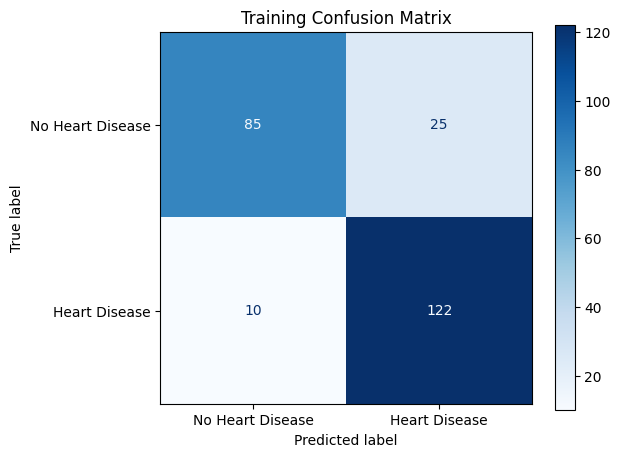

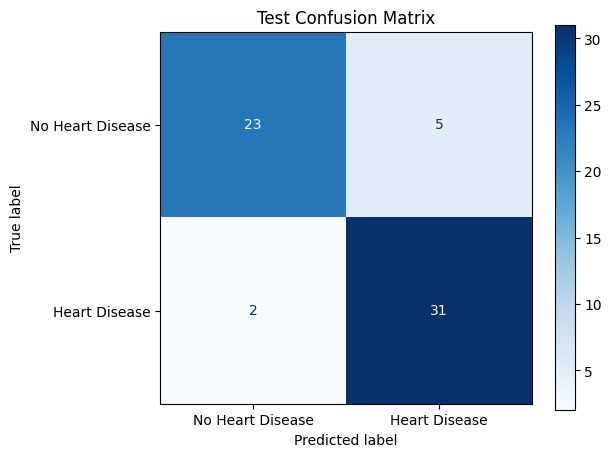

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       110
           1       0.83      0.92      0.87       132

    accuracy                           0.86       242
   macro avg       0.86      0.85      0.85       242
weighted avg       0.86      0.86      0.85       242

Training Set Confusion Matrix:
[[ 85  25]
 [ 10 122]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Test Set Confusion Matrix:
[[23  5]
 [ 2 31]]


<Figure size 1000x600 with 0 Axes>

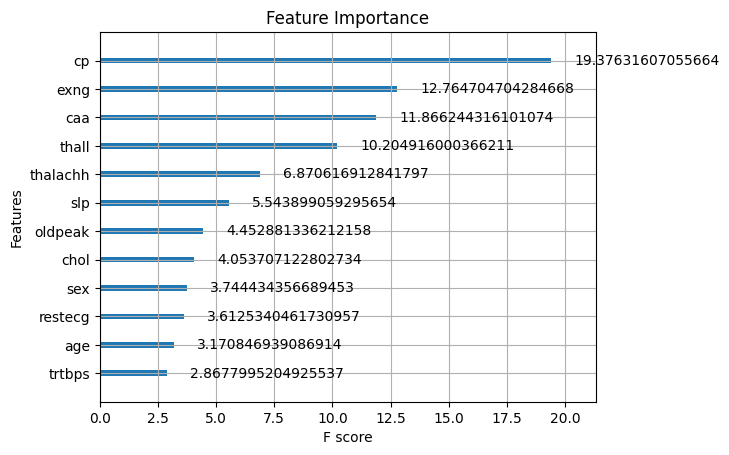

In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/AI: Heart Attack/heart.csv')

# Pre-processing / dropping output
X = heart_df.drop(columns=['output'])
y = heart_df['output']

feature_names = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Added this line
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

#Splitting data
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=701, stratify=y)

# Splitting data with new code
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=701, stratify=y
)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=701)

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=701)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
# Support will only show true instances, not synthetic samples
# Results increase minority class/ shows oversampling
# Printing to view how many synthetic samples
print("Class distribution after SMOTE:", Counter(y_train_resampled))

xgb_model = XGBClassifier(eval_metric='logloss', random_state=701)

# Param grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150], # Number of trees or boosting rounds
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2], # Step size for weight updates
    'reg_alpha': [0, 0.1, 1], # L1 regularization to prevent overfitting
    'reg_lambda': [1, 10, 100], # L2 regulartization to prevent overfitting
    'subsample': [0.8, 1.0], # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0] # Fractions of features used per tree
}

# Grid search w/ 5 fold cross validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=701),
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to data
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluating best model on test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

y_train_pred = best_xgb_model.predict(X_train)
# Training set evaluation
y_train_pred = best_xgb_model.predict(X_train)
train_conf_mat = confusion_matrix(y_train, y_train_pred)
fig, ax1 = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=train_conf_mat,
                       display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax1, cmap='Blues')
ax1.set_title('Training Confusion Matrix')
plt.show()

# Test set evaluation
y_pred = best_xgb_model.predict(X_test)
test_conf_mat = confusion_matrix(y_test, y_pred)
fig, ax2 = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=test_conf_mat,
                       display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax2, cmap='Blues')
ax2.set_title('Test Confusion Matrix')
plt.show()

print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Training Set Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# plt.figure(figsize=(10, 6))
# plot_importance(best_xgb_model, importance_type='weight', max_num_features=len(feature_names))
# plt.title('Feature Importance')
# plt.xlabel('Score')
# plt.yticks(range(len(feature_names)), feature_names)
# plt.show()
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

<Figure size 1000x800 with 0 Axes>

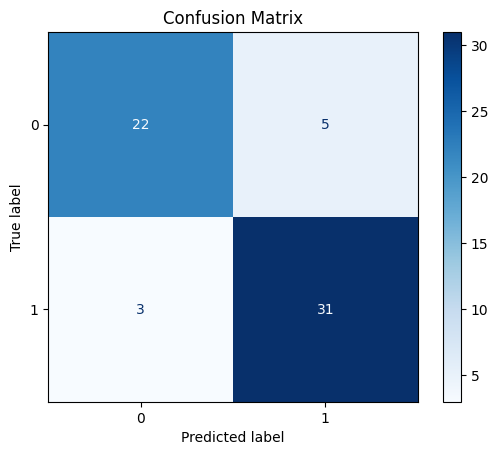


Full Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.86      0.91      0.89        34

    accuracy                           0.87        61
   macro avg       0.87      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



In [ ]:
# Split the data into training and testing sets for confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=701)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print full classification report
print("\nFull Classification Report:")
print(classification_report(y_test, y_pred))

#Bagging

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


Confusion Matrix:
 [[24  5]
 [ 4 28]]

Accuracy Score: 0.8524590163934426


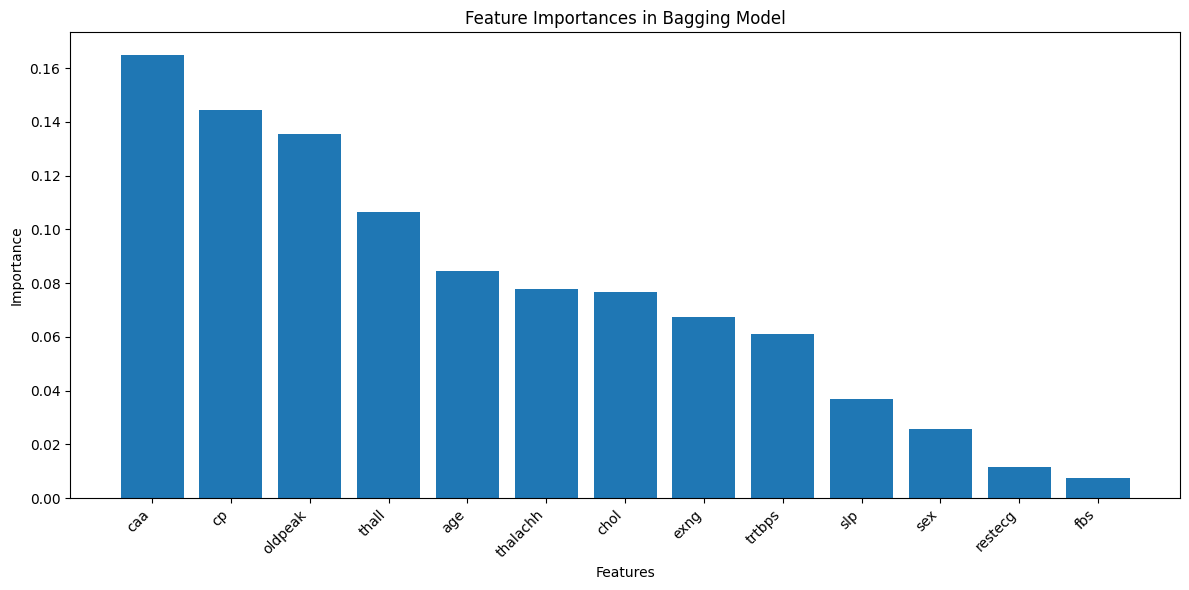


Feature Importances:
caa: 0.1651
cp: 0.1444
oldpeak: 0.1353
thall: 0.1065
age: 0.0845
thalachh: 0.0778
chol: 0.0765
exng: 0.0673
trtbps: 0.0610
slp: 0.0369
sex: 0.0257
restecg: 0.0115
fbs: 0.0074

Bagging Classifier Performance:

Cross-validation scores: [0.81967213 0.90163934 0.75409836 0.75       0.75      ]
Mean CV score: 0.795 (+/- 0.119)

Single Decision Tree Performance:

Cross-validation scores: [0.75409836 0.85245902 0.75409836 0.7        0.71666667]
Mean CV score: 0.755 (+/- 0.106)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Store feature names
feature_names = X.columns.tolist()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the bagging classifier
# Remove max_features parameter to use all features in each tree
base_tree = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=100,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred = bagging_model.predict(X_test)

# Print metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Alternative feature importance calculation
def plot_feature_importance(model, feature_names):
    # Get feature importances from all trees
    importances = np.zeros(len(feature_names))
    n_estimators = len(model.estimators_)

    # Sum up feature importances from all trees
    for estimator in model.estimators_:
        importances += estimator.feature_importances_

    # Average the importances
    importances /= n_estimators

    # Sort importances
    indices = np.argsort(importances)[::-1]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances in Bagging Model')
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    # Print feature importances
    print("\nFeature Importances:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Plot feature importance
plot_feature_importance(bagging_model, feature_names)

# Function to evaluate model with cross-validation
from sklearn.model_selection import cross_val_score

def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Evaluate models with cross-validation
print("\nBagging Classifier Performance:")
evaluate_model_cv(bagging_model, X_scaled, y)

print("\nSingle Decision Tree Performance:")
single_tree = DecisionTreeClassifier(random_state=42)
evaluate_model_cv(single_tree, X_scaled, y)

Original class distribution: Counter({1: 133, 0: 109})
Resampled class distribution: Counter({1: 133, 0: 133})

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


Confusion Matrix:
 [[24  5]
 [ 4 28]]

Accuracy Score: 0.8524590163934426


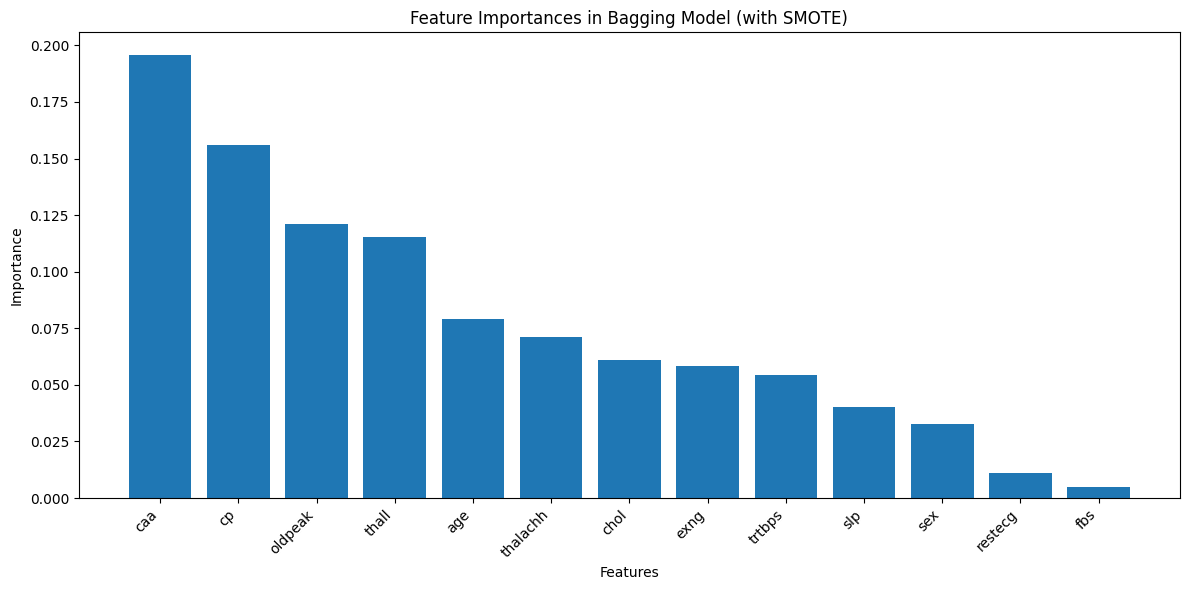


Feature Importances:
caa: 0.1959
cp: 0.1559
oldpeak: 0.1209
thall: 0.1152
age: 0.0789
thalachh: 0.0709
chol: 0.0609
exng: 0.0584
trtbps: 0.0542
slp: 0.0404
sex: 0.0327
restecg: 0.0110
fbs: 0.0047

Bagging Classifier Performance:

Cross-validation scores: [0.81967213 0.90163934 0.75409836 0.75       0.75      ]
Mean CV score: 0.795 (+/- 0.119)

Single Decision Tree Performance:

Cross-validation scores: [0.75409836 0.85245902 0.75409836 0.7        0.71666667]
Mean CV score: 0.755 (+/- 0.106)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Store feature names
feature_names = X.columns.tolist()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print class distribution before oversampling
print("Original class distribution:", Counter(y_train))

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after oversampling
print("Resampled class distribution:", Counter(y_train_resampled))

# Create and train the bagging classifier
base_tree = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=100,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model on the resampled data
bagging_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = bagging_model.predict(X_test)

# Print metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

def plot_feature_importance(model, feature_names):
    # Get feature importances from all trees
    importances = np.zeros(len(feature_names))
    n_estimators = len(model.estimators_)

    # Sum up feature importances from all trees
    for estimator in model.estimators_:
        importances += estimator.feature_importances_

    # Average the importances
    importances /= n_estimators

    # Sort importances
    indices = np.argsort(importances)[::-1]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances in Bagging Model (with SMOTE)')
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    # Print feature importances
    print("\nFeature Importances:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Plot feature importance
plot_feature_importance(bagging_model, feature_names)

# Function to evaluate model with cross-validation
from sklearn.model_selection import cross_val_score

def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Evaluate models with cross-validation
print("\nBagging Classifier Performance:")
evaluate_model_cv(bagging_model, X_scaled, y)

print("\nSingle Decision Tree Performance:")
single_tree = DecisionTreeClassifier(random_state=42)
evaluate_model_cv(single_tree, X_scaled, y)

TRAINING SET PERFORMANCE:
------------------------
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       133

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242


Confusion Matrix:
 [[109   0]
 [  0 133]]

Accuracy Score: 1.0

TEST SET PERFORMANCE:
------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


Confusion Matrix:
 [[24  5]
 [ 4 28]]

Accuracy Score: 0.8524590163934426


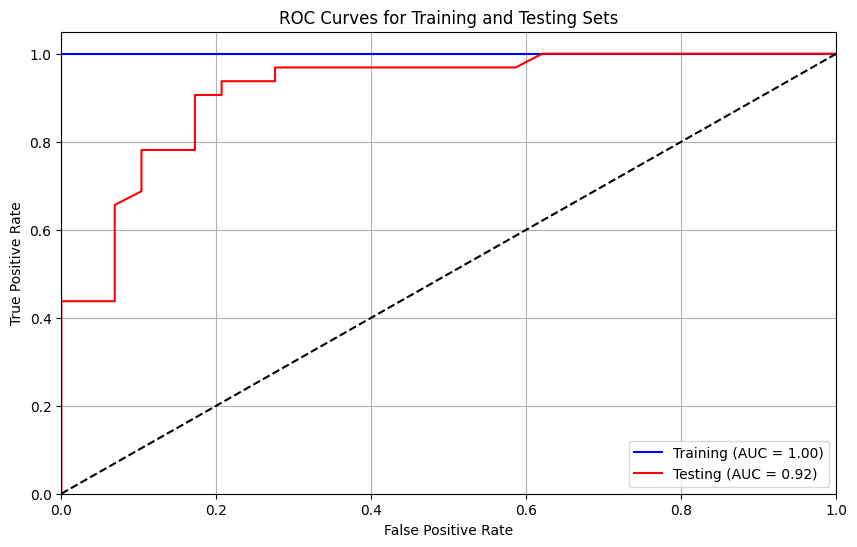


PERFORMANCE COMPARISON:
------------------------
Training Accuracy: 1.0000
Testing Accuracy:  0.8525
Difference (Train - Test): 0.1475


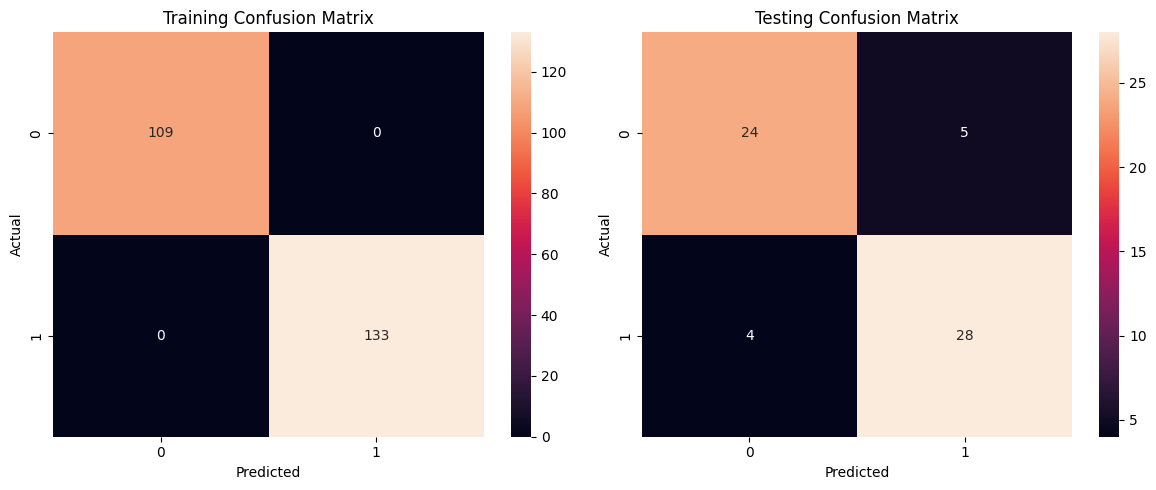

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the bagging classifier
base_tree = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=100,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model
bagging_model.fit(X_train, y_train)

# Get predictions for both training and testing sets
y_train_pred = bagging_model.predict(X_train)
y_test_pred = bagging_model.predict(X_test)

# Get probability predictions for ROC curve
y_train_prob = bagging_model.predict_proba(X_train)[:, 1]
y_test_prob = bagging_model.predict_proba(X_test)[:, 1]

# Print training set performance
print("TRAINING SET PERFORMANCE:")
print("------------------------")
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nAccuracy Score:", accuracy_score(y_train, y_train_pred))

# Print testing set performance
print("\nTEST SET PERFORMANCE:")
print("------------------------")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_test_pred))

# Calculate ROC curves
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)


# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Training (AUC = {train_auc:.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Testing (AUC = {test_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Sets')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate and print the difference in performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nPERFORMANCE COMPARISON:")
print("------------------------")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('Testing Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Original training set class distribution:
Counter({1: 133, 0: 109})

Resampled training set class distribution:
Counter({1: 133, 0: 133})

TRAINING SET PERFORMANCE (on resampled data):
------------------------
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       133

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266


Confusion Matrix:
 [[133   0]
 [  0 133]]

Accuracy Score: 1.0

TEST SET PERFORMANCE:
------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.

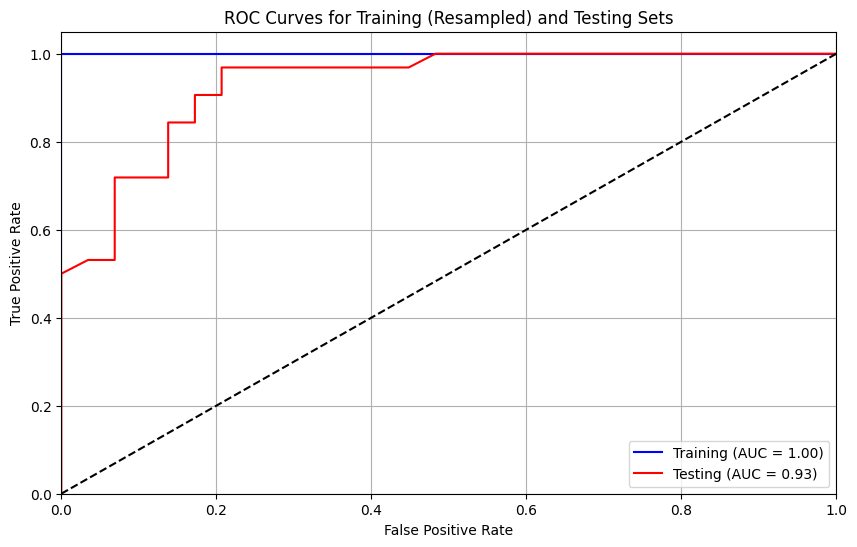


PERFORMANCE COMPARISON:
------------------------
Training Accuracy (on resampled data): 1.0000
Testing Accuracy: 0.8525
Difference (Train - Test): 0.1475


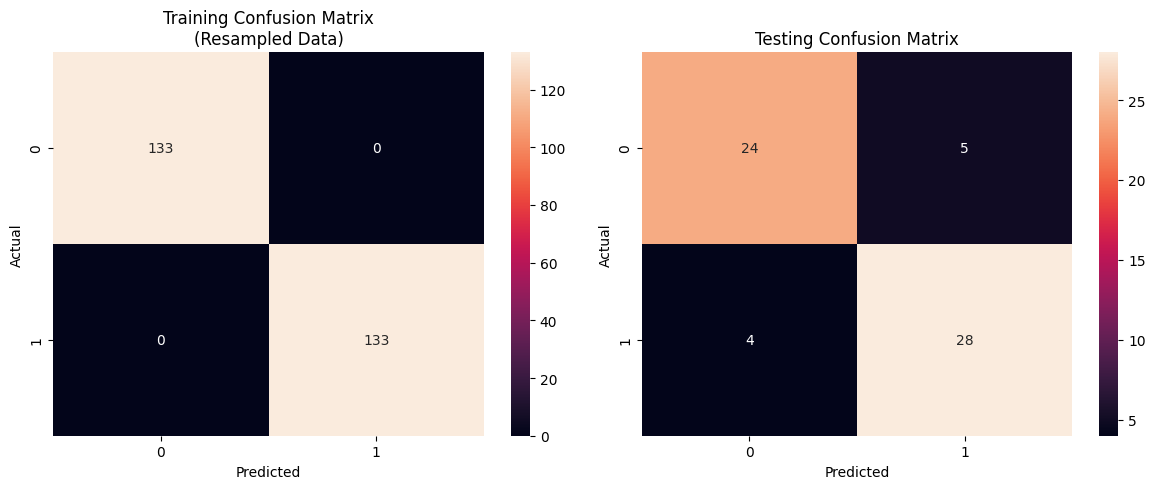

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print original class distribution
print("Original training set class distribution:")
print(Counter(y_train))

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print resampled class distribution
print("\nResampled training set class distribution:")
print(Counter(y_train_resampled))

# Create and train the bagging classifier
base_tree = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=100,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model on resampled data
bagging_model.fit(X_train_resampled, y_train_resampled)

# Get predictions for both training and testing sets
# Note: Use resampled training data for training predictions
y_train_pred = bagging_model.predict(X_train_resampled)
y_test_pred = bagging_model.predict(X_test)

# Get probability predictions for ROC curve
y_train_prob = bagging_model.predict_proba(X_train_resampled)[:, 1]
y_test_prob = bagging_model.predict_proba(X_test)[:, 1]

# Print training set performance (on resampled data)
print("\nTRAINING SET PERFORMANCE (on resampled data):")
print("------------------------")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_resampled, y_train_pred))
print("\nAccuracy Score:", accuracy_score(y_train_resampled, y_train_pred))

# Print testing set performance
print("\nTEST SET PERFORMANCE:")
print("------------------------")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_test_pred))

# Calculate ROC curves
train_fpr, train_tpr, _ = roc_curve(y_train_resampled, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Training (AUC = {train_auc:.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Testing (AUC = {test_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training (Resampled) and Testing Sets')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate and print the difference in performance
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nPERFORMANCE COMPARISON:")
print("------------------------")
print(f"Training Accuracy (on resampled data): {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_train_resampled, y_train_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('Training Confusion Matrix\n(Resampled Data)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('Testing Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Starting Random Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Time taken for tuning: 21.38 seconds

Best Parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'max_samples': 0.8599130323948154, 'n_estimators': 58}
Best Cross-Validation Score: 0.7850823045267489

BEST MODEL PERFORMANCE:
------------------------------

TRAINING SET:
Accuracy: 0.9504132231404959

Confusion Matrix:
[[ 98   9]
 [  3 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       107
           1       0.94      0.98      0.96       135

    accuracy                           0.95       242
   macro avg       0.95      0.95      0.95       242
weighted avg       0.95      0.95      0.95       242


TEST SET:
Accuracy: 0.8524590163934426

Confusion Matrix:
[[22  9]
 [ 0 30]]

Classification Report:
              precision    recall  f1-score   support

       

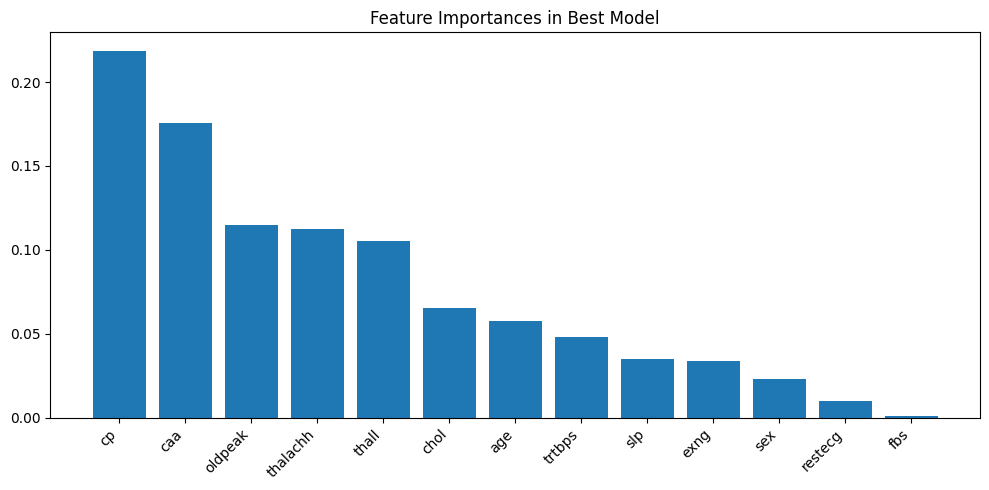


Top 5 Most Important Features:
cp: 0.2187
caa: 0.1755
oldpeak: 0.1150
thalachh: 0.1124
thall: 0.1051

PERFORMANCE COMPARISON:
------------------------------
Training Accuracy: 0.9504
Testing Accuracy:  0.8525
Difference (Train - Test): 0.0980


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Start timing
start_time = time.time()

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Define the base model
base_tree = DecisionTreeClassifier(random_state=42)

# Create the bagging classifier
bagging = BaggingClassifier(
    estimator=base_tree,
    n_jobs=-1,  # Use all CPU cores
    max_features=1.0  # Use all features for each tree
)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 150),
    'max_samples': uniform(0.6, 0.3),
    'estimator__max_depth': [3, 5, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit the random search
print("Starting Random Search...")
random_search.fit(X_train, y_train)

# Print the time taken
end_time = time.time()
print(f"\nTime taken for tuning: {end_time - start_time:.2f} seconds")

# Print the best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Print results
print("\nBEST MODEL PERFORMANCE:")
print("-" * 30)
print("\nTRAINING SET:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTEST SET:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Modified feature importance calculation
def plot_feature_importance(model, feature_names):
    n_features = len(feature_names)
    importances = np.zeros(n_features)
    n_estimators = len(model.estimators_)

    # Calculate feature importances only for trees using all features
    valid_trees = 0
    for tree in model.estimators_:
        try:
            importances += tree.feature_importances_
            valid_trees += 1
        except:
            continue

    if valid_trees > 0:
        importances /= valid_trees

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title('Feature Importances in Best Model')
        plt.bar(range(n_features), importances[indices])
        plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Print top 5 feature importances
        print("\nTop 5 Most Important Features:")
        for idx in indices[:5]:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("Could not calculate feature importances due to varying feature subset sizes")

# Plot feature importance for best model
plot_feature_importance(best_model, X.columns)

# Print performance comparison
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nPERFORMANCE COMPARISON:")
print("-" * 30)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")

# Best Parameters

Best Parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'max_samples': 0.6406745803741039, 'n_estimators': 60}


Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'max_samples': 0.8332984471338418, 'n_estimators': 129}
Best Cross-Validation Score: 0.8225308641975309


Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'max_samples': 0.8332984471338418, 'n_estimators': 129}







Original training set class distribution:
Counter({1: 132, 0: 110})

Resampled training set class distribution:
Counter({1: 132, 0: 132})
Starting Random Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Time taken for tuning: 11.69 seconds

Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'max_samples': 0.6759042114431576, 'n_estimators': 56}
Best Cross-Validation Score: 0.8484848484848485

BEST MODEL PERFORMANCE:
------------------------------

TRAINING SET (on resampled data):
Accuracy: 0.8825757575757576

Confusion Matrix:
[[114  18]
 [ 13 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       132
           1       0.87      0.90      0.88       132

    accuracy                           0.88       264
   macro avg       0.88      0.88      0.88       264
weighted avg       0.88      0.88      0.88       264


TEST 

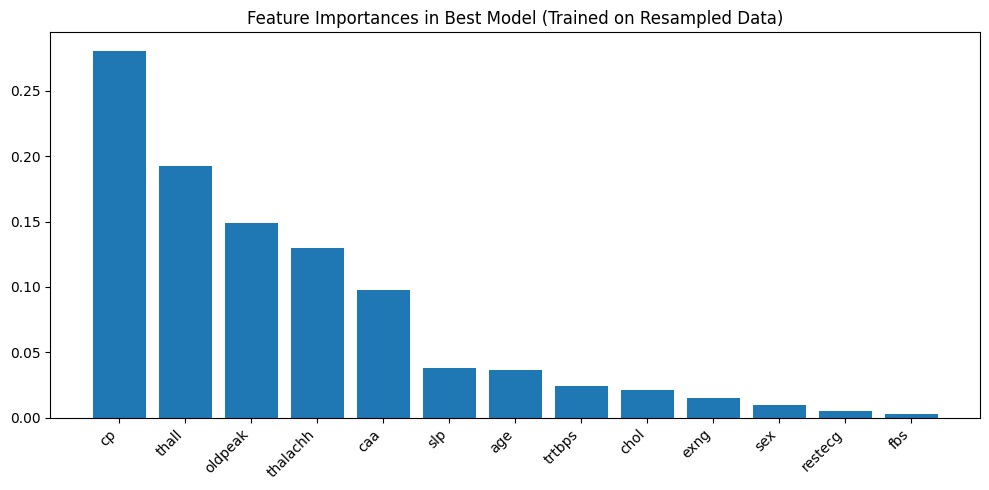


Top 5 Most Important Features:
cp: 0.2808
thall: 0.1923
oldpeak: 0.1491
thalachh: 0.1296
caa: 0.0976

PERFORMANCE COMPARISON:
------------------------------
Training Accuracy (on resampled data): 0.8826
Testing Accuracy: 0.8361
Difference (Train - Test): 0.0465


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Start timing
start_time = time.time()

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Print original class distribution
print("Original training set class distribution:")
print(Counter(y_train))

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print resampled class distribution
print("\nResampled training set class distribution:")
print(Counter(y_train_resampled))

# Define the base model
base_tree = DecisionTreeClassifier(random_state=42)

# Create the bagging classifier
bagging = BaggingClassifier(
    estimator=base_tree,
    n_jobs=-1,  # Use all CPU cores
    max_features=1.0  # Use all features for each tree
)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 150),
    'max_samples': uniform(0.6, 0.3),
    'estimator__max_depth': [3, 5, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit the random search on resampled data
print("Starting Random Search...")
random_search.fit(X_train_resampled, y_train_resampled)

# Print the time taken
end_time = time.time()
print(f"\nTime taken for tuning: {end_time - start_time:.2f} seconds")

# Print the best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions with the best model
y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)

# Print results
print("\nBEST MODEL PERFORMANCE:")
print("-" * 30)
print("\nTRAINING SET (on resampled data):")
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train_resampled, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTEST SET:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

def plot_feature_importance(model, feature_names):
    n_features = len(feature_names)
    importances = np.zeros(n_features)
    n_estimators = len(model.estimators_)

    # Calculate feature importances only for trees using all features
    valid_trees = 0
    for tree in model.estimators_:
        try:
            importances += tree.feature_importances_
            valid_trees += 1
        except:
            continue

    if valid_trees > 0:
        importances /= valid_trees

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title('Feature Importances in Best Model (Trained on Resampled Data)')
        plt.bar(range(n_features), importances[indices])
        plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Print top 5 feature importances
        print("\nTop 5 Most Important Features:")
        for idx in indices[:5]:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("Could not calculate feature importances due to varying feature subset sizes")

# Plot feature importance for best model
plot_feature_importance(best_model, X.columns)

# Print performance comparison
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nPERFORMANCE COMPARISON:")
print("-" * 30)
print(f"Training Accuracy (on resampled data): {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")

Class distribution before SMOTE: Counter({1: 132, 0: 110})
Class distribution after SMOTE: Counter({1: 132, 0: 132})
Starting Grid Search...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Time taken for tuning: 52.85 seconds

Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}
Best Cross-Validation Score: 0.9017094017094017


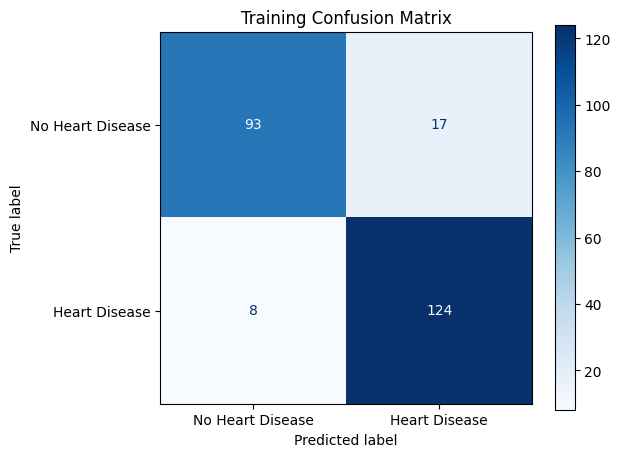

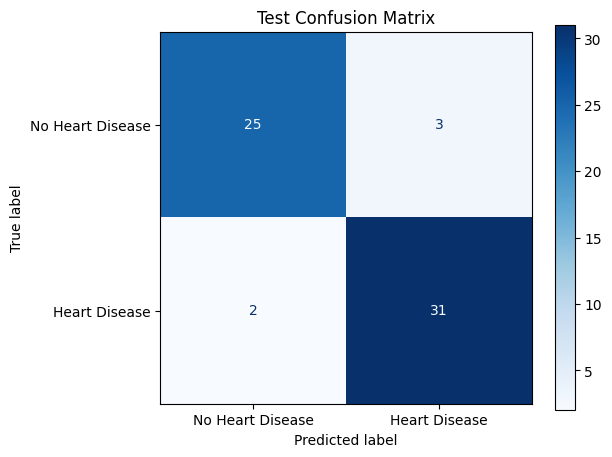


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       110
           1       0.88      0.94      0.91       132

    accuracy                           0.90       242
   macro avg       0.90      0.89      0.89       242
weighted avg       0.90      0.90      0.90       242


Training Set Confusion Matrix:
[[ 93  17]
 [  8 124]]

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.91      0.94      0.93        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61


Test Set Confusion Matrix:
[[25  3]
 [ 2 31]]
Could not calculate feature importances

PERFORMANCE COMPARISON:
------------------------------
Training Accuracy: 0.8967
Testing Accuracy: 0.9180
Difference (Train - Test): 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import time


# Start timing
start_time = time.time()

# Prepare the data
X = heart_df_new.drop(columns=['output', 'age_group'])
y = heart_df_new['output']

feature_names = X.columns.tolist()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=701, stratify=y
)

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=701)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Define base model and bagging classifier
base_tree = DecisionTreeClassifier(random_state=701)
bagging_model = BaggingClassifier(
    estimator=base_tree,
    random_state=701,
    n_jobs=-1
)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],  # Reduced from [50, 100, 150]
    'max_samples': [0.7, 1.0],  # Removed 0.5
    'max_features': [0.7, 1.0],  # Removed 0.5
    'bootstrap': [True],  # Removed False option
    'bootstrap_features': [False],  # Removed True option
    'estimator__max_depth': [3, 5],  # Removed 7
    'estimator__min_samples_split': [2, 5],  # Removed 10
    'estimator__min_samples_leaf': [1, 2]  # Removed 4
}

# Grid search with 5-fold cross validation
grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=701),
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to data
print("Starting Grid Search...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Print timing
end_time = time.time()
print(f"\nTime taken for tuning: {end_time - start_time:.2f} seconds")

# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Get best model
best_bagging_model = grid_search.best_estimator_

# Training set evaluation
y_train_pred = best_bagging_model.predict(X_train)
train_conf_mat = confusion_matrix(y_train, y_train_pred)

# Plot training confusion matrix
fig, ax1 = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=train_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax1, cmap='Blues')
ax1.set_title('Training Confusion Matrix')
plt.show()

# Test set evaluation
y_test_pred = best_bagging_model.predict(X_test)
test_conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot test confusion matrix
fig, ax2 = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=test_conf_mat,
                      display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=ax2, cmap='Blues')
ax2.set_title('Test Confusion Matrix')
plt.show()

# Print classification reports
print("\nTraining Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTraining Set Confusion Matrix:")
print(train_conf_mat)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Set Confusion Matrix:")
print(test_conf_mat)

# Feature importance calculation and visualization
def plot_feature_importance(model, feature_names):
    n_features = len(feature_names)
    importances = np.zeros(n_features)
    n_estimators = len(model.estimators_)

    # Calculate average feature importance across all trees
    valid_trees = 0
    for tree in model.estimators_:
        try:
            importances += tree.feature_importances_
            valid_trees += 1
        except:
            continue

    if valid_trees > 0:
        importances /= valid_trees

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances in Bagging Model')
        plt.bar(range(n_features), importances[indices])
        plt.xticks(range(n_features), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Print top 5 features
        print("\nTop 5 Most Important Features:")
        for idx in indices[:5]:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("Could not calculate feature importances")

# Plot feature importance
plot_feature_importance(best_bagging_model, feature_names)

# Print performance comparison
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nPERFORMANCE COMPARISON:")
print("-" * 30)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")

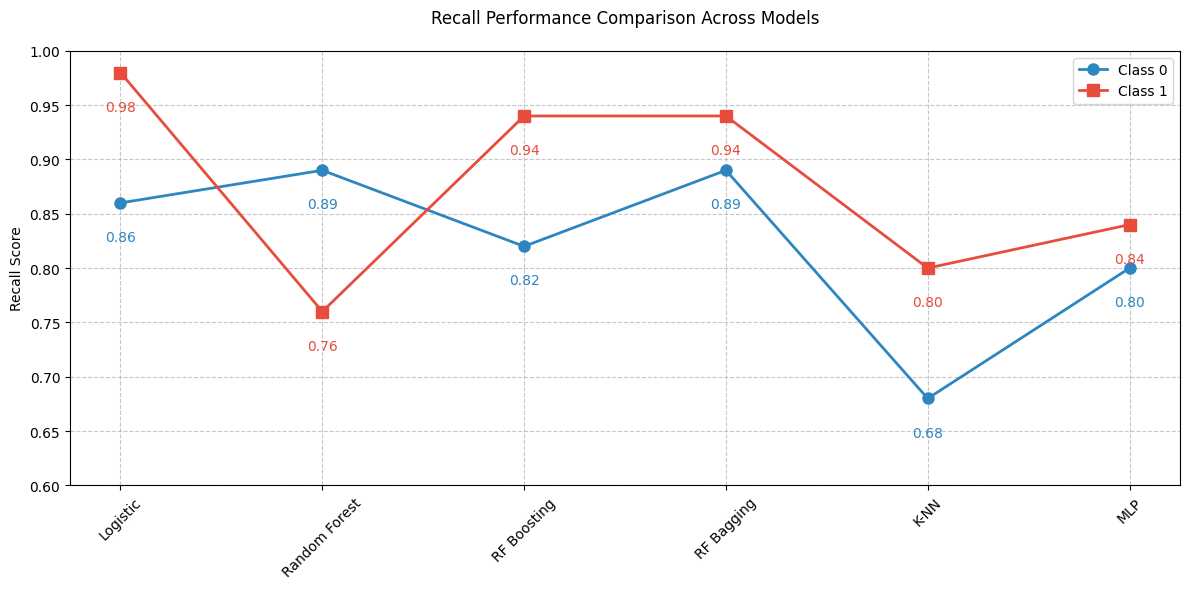

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation with all models
models = ['Logistic', 'Random Forest', 'RF Boosting', 'RF Bagging', 'K-NN', 'MLP']
recall_0 = [0.86, 0.89, 0.82, 0.89, 0.68, 0.80]
recall_1 = [0.98, 0.76, 0.94, 0.94, 0.80, 0.84]

plt.figure(figsize=(12, 6))  # Increased figure width to accommodate more models

# Create line plots
plt.plot(models, recall_0, 'o-', label='Class 0', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Class 1', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.01, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.01, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)  # Adjusted to accommodate K-NN's lower recall value
plt.xticks(range(len(models)), models, rotation=45)
plt.tight_layout()

plt.show()

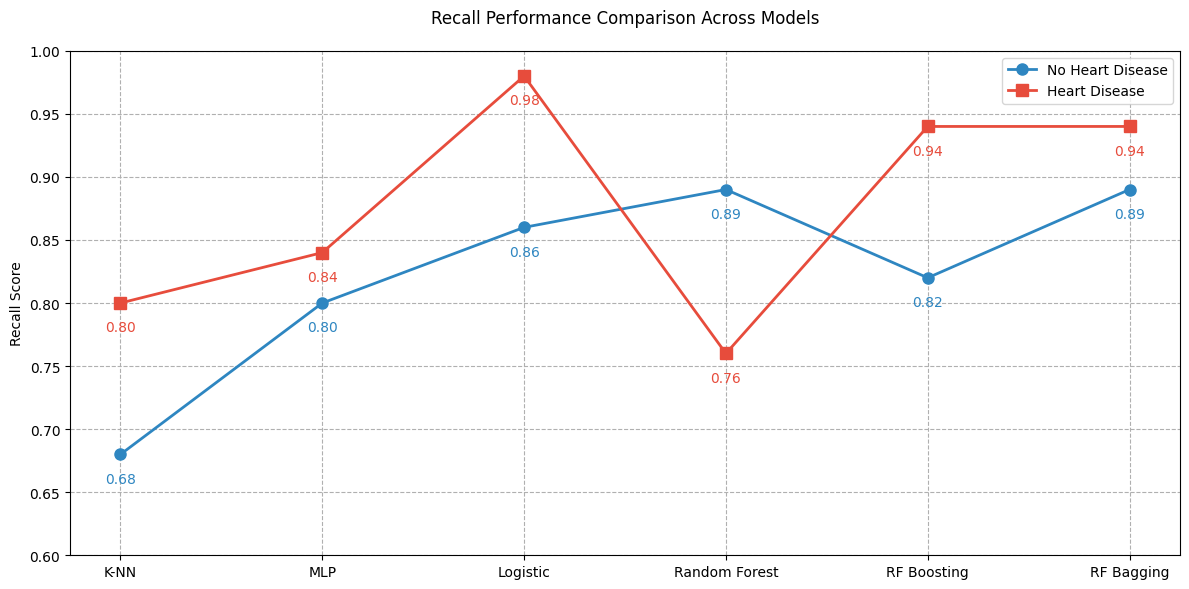

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation with reordered models
models = ['K-NN', 'MLP', 'Logistic', 'Random Forest', 'RF Boosting', 'RF Bagging']
recall_0 = [0.68, 0.80, 0.86, 0.89, 0.82, 0.89]
recall_1 = [0.80, 0.84, 0.98, 0.76, 0.94, 0.94]

plt.figure(figsize=(12, 6))

# Create line plots
plt.plot(models, recall_0, 'o-', label='No Heart Disease', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Heart Disease', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.001, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.001, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--')
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)
plt.xticks(range(len(models)), models, rotation=0)
plt.tight_layout()

plt.show()

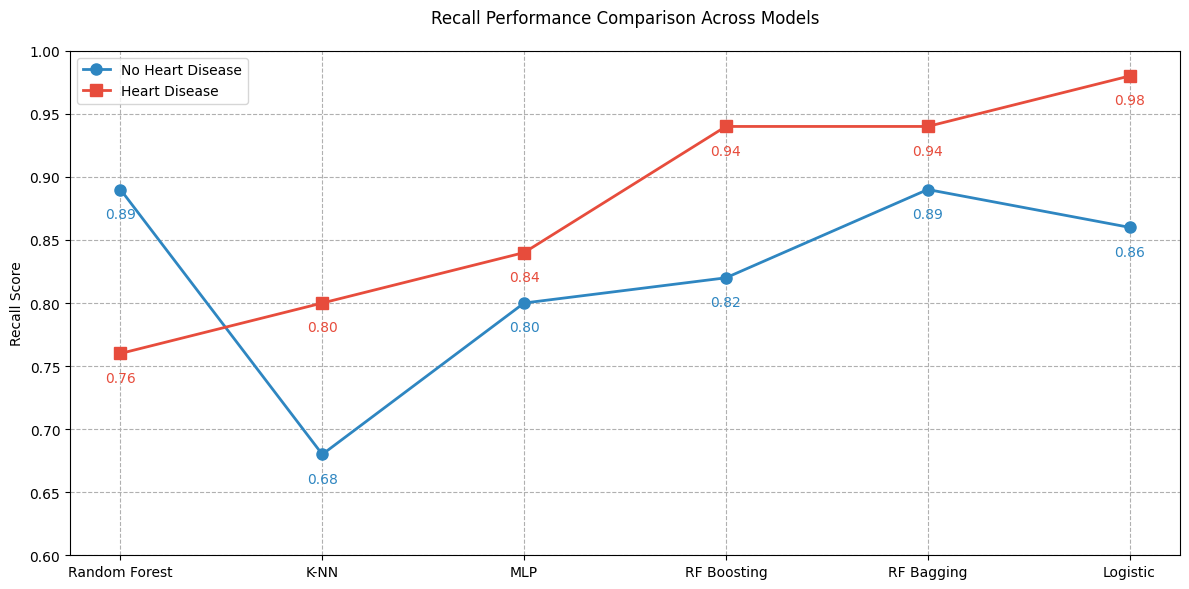

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation with models ordered by Heart Disease recall (ascending)
models = ['Random Forest', 'K-NN', 'MLP', 'RF Boosting', 'RF Bagging', 'Logistic']
recall_0 = [0.89, 0.68, 0.80, 0.82, 0.89, 0.86]
recall_1 = [0.76, 0.80, 0.84, 0.94, 0.94, 0.98]

plt.figure(figsize=(12, 6))

# Create line plots
plt.plot(models, recall_0, 'o-', label='No Heart Disease', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Heart Disease', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.001, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.001, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--')
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)
plt.xticks(range(len(models)), models, rotation=0)
plt.tight_layout()

plt.show()


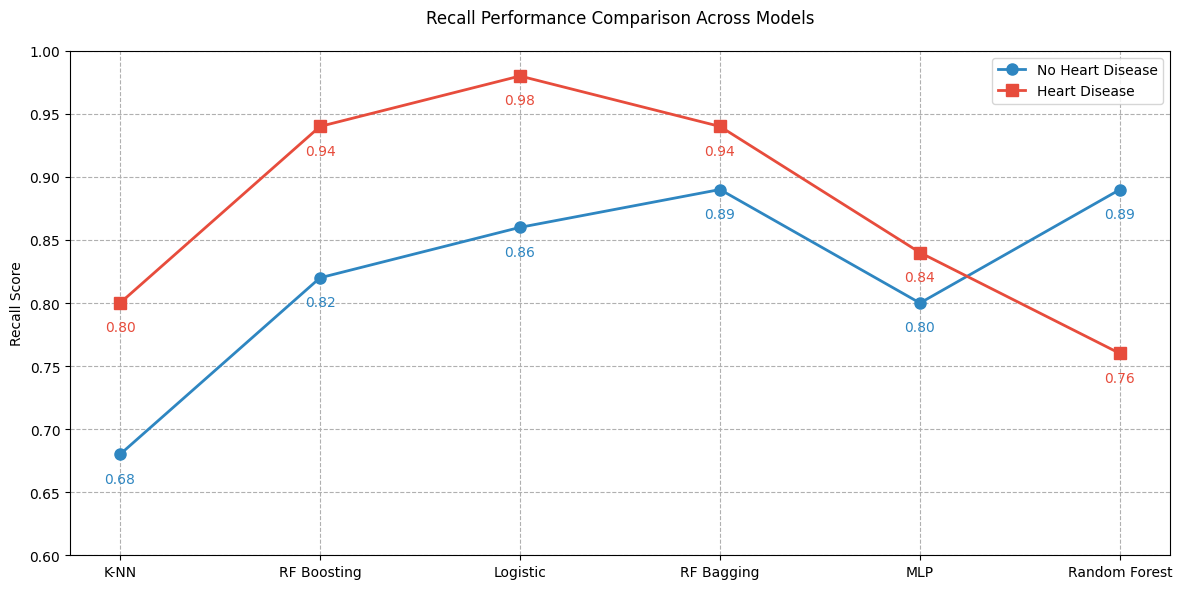

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate differences and sort
models = ['Random Forest', 'K-NN', 'MLP', 'RF Boosting', 'RF Bagging', 'Logistic']
recall_0 = [0.89, 0.68, 0.80, 0.82, 0.89, 0.86]
recall_1 = [0.76, 0.80, 0.84, 0.94, 0.94, 0.98]

# Calculate differences and create sorted indices
differences = [r0 - r1 for r0, r1 in zip(recall_0, recall_1)]
sorted_indices = np.argsort(differences)

# Reorder all data
models = [models[i] for i in sorted_indices]
recall_0 = [recall_0[i] for i in sorted_indices]
recall_1 = [recall_1[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))

# Create line plots
plt.plot(models, recall_0, 'o-', label='No Heart Disease', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Heart Disease', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.001, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.001, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--')
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)
plt.xticks(range(len(models)), models, rotation=0)
plt.tight_layout()

plt.show()

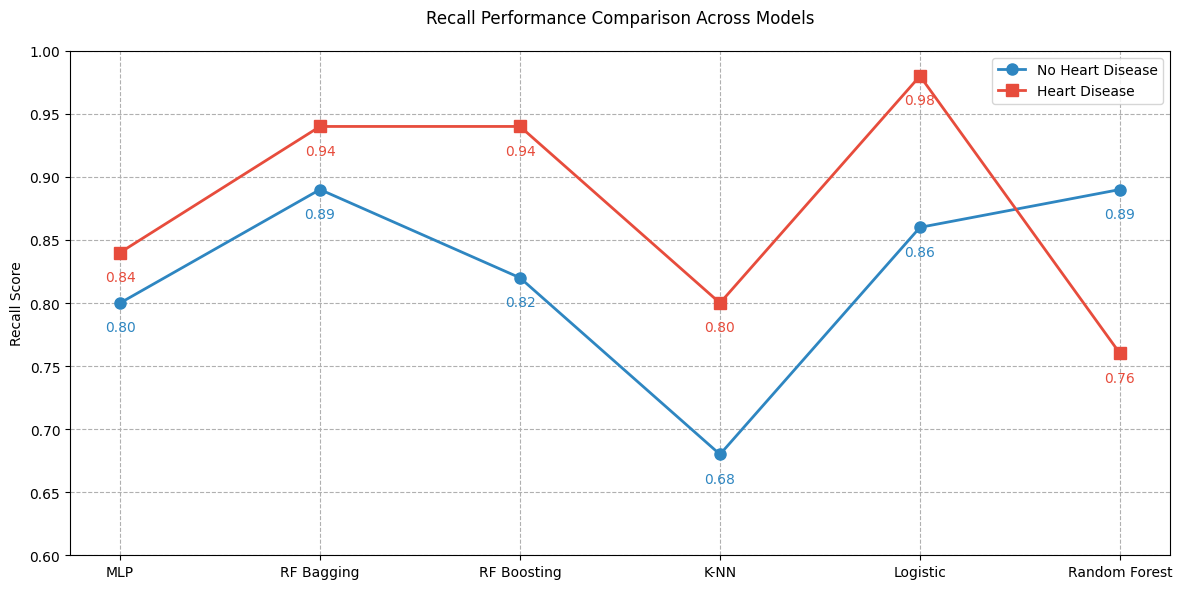

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate differences and sort
models = ['Random Forest', 'K-NN', 'MLP', 'RF Boosting', 'RF Bagging', 'Logistic']
recall_0 = [0.89, 0.68, 0.80, 0.82, 0.89, 0.86]
recall_1 = [0.76, 0.80, 0.84, 0.94, 0.94, 0.98]

# Calculate absolute differences and create sorted indices
differences = [abs(r1 - r0) for r0, r1 in zip(recall_0, recall_1)]
sorted_indices = np.argsort(differences)

# Reorder all data
models = [models[i] for i in sorted_indices]
recall_0 = [recall_0[i] for i in sorted_indices]
recall_1 = [recall_1[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))

# Create line plots
plt.plot(models, recall_0, 'o-', label='No Heart Disease', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Heart Disease', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.001, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.001, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--')
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)
plt.xticks(range(len(models)), models, rotation=0)
plt.tight_layout()

plt.show()

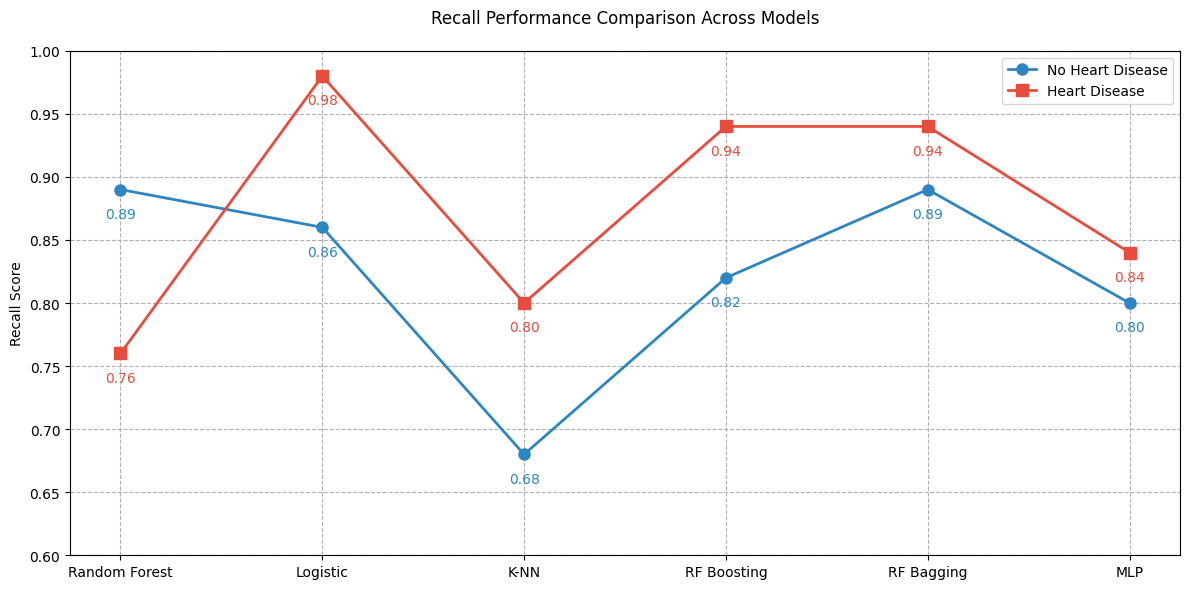

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate differences and sort
models = ['Random Forest', 'K-NN', 'MLP', 'RF Boosting', 'RF Bagging', 'Logistic']
recall_0 = [0.89, 0.68, 0.80, 0.82, 0.89, 0.86]
recall_1 = [0.76, 0.80, 0.84, 0.94, 0.94, 0.98]

# Calculate absolute differences and create sorted indices
differences = [abs(r1 - r0) for r0, r1 in zip(recall_0, recall_1)]
sorted_indices = np.argsort(differences)[::-1]  # Reversed for descending order

# Reorder all data
models = [models[i] for i in sorted_indices]
recall_0 = [recall_0[i] for i in sorted_indices]
recall_1 = [recall_1[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))

# Create line plots
plt.plot(models, recall_0, 'o-', label='No Heart Disease', linewidth=2, markersize=8, color='#2E86C1')
plt.plot(models, recall_1, 's-', label='Heart Disease', linewidth=2, markersize=8, color='#E74C3C')

# Add value labels below points
for i, (v0, v1) in enumerate(zip(recall_0, recall_1)):
    plt.text(i, v0 - 0.001, f'\n{v0:.2f}', ha='center', va='top', color='#2E86C1')
    plt.text(i, v1 - 0.001, f'\n{v1:.2f}', ha='center', va='top', color='#E74C3C')

# Customize the plot
plt.title('Recall Performance Comparison Across Models', pad=20, size=12)
plt.ylabel('Recall Score')
plt.grid(True, linestyle='--')
plt.legend()

# Adjust layout
plt.ylim(0.60, 1.0)
plt.xticks(range(len(models)), models, rotation=0)
plt.tight_layout()

plt.show()